# BMG SmartReach - MVP de Inteligência em Vendas

### BMG SMARTREACH - MVP DE INTELIGÊNCIA EM VENDAS

**Objetivo**
Personalizar ofertas bancárias respondendo:
1. Quem é o cliente (perfil/cluster)
2. Qual produto sugerir (consignado/cartão/investimento)
3. Por qual canal abordar (WhatsApp/Email/App/SMS)
4. Qual tom de linguagem usar

- **Público-alvo:** Baixa renda e idosos (foco em consignado INSS)
- **Volume:** 20.000+ clientes sintéticos
- **Abordagem:** Pipeline completo com ML + explicabilidade

**Desenvolvedor:** André Cini
**Data:** 2025-16-08

### 1. Imports e Configurações ⚙️

In [114]:
# Imports necessários
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List, Optional
import random

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, roc_auc_score,
                             silhouette_score, davies_bouldin_score,
                             calinski_harabasz_score)
from typing import Tuple, Dict, List

# Método do Cotovelo
from scipy.stats import skew
from kneed import KneeLocator

# LightGBM (melhor que RF para esse caso)
try:
    import lightgbm as lgb
    HAS_LIGHTGBM = True
except ImportError:
    HAS_LIGHTGBM = False
    print("⚠️  LightGBM não instalado. Usando RandomForest como fallback.")

# SHAP para explicabilidade
try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print("⚠️  SHAP não instalado. Usando feature importance padrão.")

# Reprodutibilidade
SEED = 42
np.random.seed(SEED)

# Configuração de plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ Imports concluídos!")
print(f"📦 LightGBM disponível: {HAS_LIGHTGBM}")
print(f"📦 SHAP disponível: {HAS_SHAP}")

✅ Imports concluídos!
📦 LightGBM disponível: True
📦 SHAP disponível: True


### 2. Geração de Dados Sintéticos 💾

In [115]:
# === CONFIGURAÇÕES DE DISTRIBUIÇÃO ===

# Proporções de tipos de benefício (baseado no perfil BMG)
PROPORCAO_BENEFICIOS = {
    'INSS': 0.60,              # 60% - Aposentados e pensionistas
    'Servidor Publico': 0.25,  # 25% - Funcionários públicos
    'CLT': 0.15                # 15% - Regime CLT privado
}

# Parâmetros de idade por tipo de benefício
PARAMETROS_IDADE = {
    'INSS': {
        'media': 62,      # Média de 62 anos (idade típica de aposentadoria)
        'desvio': 12,     # Desvio padrão de 12 anos
        'min': 50,        # Mínimo 50 anos
        'max': 90         # Máximo 90 anos
    },
    'Servidor Publico': {
        'media': 45,      # Média de 45 anos (carreira estabelecida)
        'desvio': 10,     # Desvio padrão de 10 anos
        'min': 30,        # Mínimo 30 anos (início de carreira pública)
        'max': 70         # Máximo 70 anos (próximo à aposentadoria)
    },
    'CLT': {
        'media': 35,      # Média de 35 anos (força de trabalho ativa)
        'desvio': 8,      # Desvio padrão de 8 anos
        'min': 18,        # Mínimo 18 anos (maioridade)
        'max': 55         # Máximo 55 anos
    }
}

# Parâmetros de renda mensal por tipo de benefício (distribuição Gamma)
PARAMETROS_RENDA = {
    'INSS': {
        'shape': 2,       # Forma da distribuição (concentração próxima ao mínimo)
        'scale': 700,     # Escala em R$
        'min': 1300,      # Mínimo ~1 salário mínimo
        'max': 4000       # Máximo ~3 salários mínimos
    },
    'Servidor Publico': {
        'shape': 3,       # Forma da distribuição
        'scale': 2000,    # Escala em R$
        'min': 3000,      # Mínimo R$ 3.000
        'max': 15000      # Máximo R$ 15.000 (cargos de gestão)
    },
    'CLT': {
        'shape': 2.5,     # Forma da distribuição
        'scale': 1000,    # Escala em R$
        'min': 1500,      # Mínimo R$ 1.500
        'max': 8000       # Máximo R$ 8.000
    }
}

# Parâmetros para tempo de relacionamento (em meses)
TEMPO_CASA = {
    'shape': 2,           # Forma da distribuição Gamma (muitos clientes novos)
    'scale': 18,          # Escala em meses (1.5 anos)
    'min': 1,             # Mínimo 1 mês
    'max': 240            # Máximo 240 meses (20 anos)
}

# Parâmetros de uso de canais digitais por faixa etária (média Poisson)
USO_CANAIS_POR_IDADE = {
    'idoso': {  # >= 60 anos
        'whatsapp': 12,   # Alto uso (principal canal de comunicação)
        'sms': 8,         # Médio-alto (familiar com SMS)
        'email': 2,       # Baixo uso
        'app': 1          # Muito baixo (resistência ao app)
    },
    'meia_idade': {  # 40-59 anos
        'whatsapp': 15,   # Muito alto uso
        'email': 8,       # Alto uso (trabalho)
        'app': 10,        # Alto uso (confortável com tecnologia)
        'sms': 3          # Baixo uso (prefere outros canais)
    },
    'jovem': {  # < 40 anos
        'app': 20,        # Muito alto uso (nativo digital)
        'whatsapp': 10,   # Alto uso
        'email': 5,       # Médio uso
        'sms': 1          # Muito baixo (canal obsoleto para jovens)
    }
}

# Probabilidades de posse de produtos por tipo de benefício
PROB_PRODUTOS = {
    'INSS': {
        'tem_consignado': 0.7,      # 70% tem consignado (produto ideal)
        'tem_cartao': 0.3,          # 30% tem cartão
        'tem_investimento': 0.05    # 5% tem investimento (baixo perfil investidor)
    },
    'Servidor Publico': {
        'tem_consignado': 0.5,      # 50% tem consignado
        'tem_cartao': 0.6,          # 60% tem cartão (maior poder aquisitivo)
        'tem_investimento': 0.4     # 40% tem investimento (perfil mais investidor)
    },
    'CLT': {
        'tem_consignado': 0.2,      # 20% tem consignado (menor elegibilidade)
        'tem_cartao': 0.7,          # 70% tem cartão (alta demanda)
        'tem_investimento': 0.15    # 15% tem investimento
    }
}

# Probabilidades de inadimplência por tipo de benefício
PROB_INADIMPLENCIA = {
    'INSS': 0.05,              # 5% inadimplente (renda estável via INSS)
    'Servidor Publico': 0.15,  # 15% inadimplente
    'CLT': 0.15                # 15% inadimplente (maior instabilidade)
}


# === FUNÇÕES AUXILIARES ===

def gerar_tipo_beneficio(n_clientes: int) -> np.ndarray:
    """Gera distribuição de tipos de benefício."""
    tipos = list(PROPORCAO_BENEFICIOS.keys())
    probabilidades = list(PROPORCAO_BENEFICIOS.values())
    
    return np.random.choice(tipos, size=n_clientes, p=probabilidades)


def gerar_idade(tipo_beneficio: np.ndarray) -> np.ndarray:
    """Gera idades correlacionadas com tipo de benefício."""
    n_clientes = len(tipo_beneficio)
    idade = np.zeros(n_clientes)
    
    for i, tipo in enumerate(tipo_beneficio):
        params = PARAMETROS_IDADE[tipo]
        # Distribuição normal clipped nos limites
        idade[i] = np.clip(
            np.random.normal(params['media'], params['desvio']),
            params['min'],
            params['max']
        )
    
    return idade.astype(int)


def gerar_renda(tipo_beneficio: np.ndarray) -> np.ndarray:
    """Gera renda mensal correlacionada com tipo de benefício."""
    n_clientes = len(tipo_beneficio)
    renda_mensal = np.zeros(n_clientes)
    
    for i, tipo in enumerate(tipo_beneficio):
        params = PARAMETROS_RENDA[tipo]
        # Distribuição Gamma (assimétrica, realista para renda)
        renda_mensal[i] = np.clip(
            np.random.gamma(params['shape'], params['scale']),
            params['min'],
            params['max']
        )
    
    return renda_mensal.round(2)


def gerar_tempo_casa(n_clientes: int) -> np.ndarray:
    """Gera tempo de relacionamento em meses."""
    tempo = np.random.gamma(
        TEMPO_CASA['shape'],
        TEMPO_CASA['scale'],
        n_clientes
    ).astype(int)
    
    return np.clip(tempo, TEMPO_CASA['min'], TEMPO_CASA['max'])


def gerar_uso_canais(idade: np.ndarray) -> dict:
    """Gera uso de canais digitais correlacionado com idade."""
    n_clientes = len(idade)
    
    uso_whatsapp = np.zeros(n_clientes)
    uso_email = np.zeros(n_clientes)
    uso_app = np.zeros(n_clientes)
    uso_sms = np.zeros(n_clientes)
    
    for i in range(n_clientes):
        # Definir perfil etário
        if idade[i] >= 60:
            perfil = 'idoso'
        elif idade[i] >= 40:
            perfil = 'meia_idade'
        else:
            perfil = 'jovem'
        
        params = USO_CANAIS_POR_IDADE[perfil]
        
        # Distribuição Poisson (adequada para contagens)
        uso_whatsapp[i] = np.random.poisson(params['whatsapp'])
        uso_email[i] = np.random.poisson(params['email'])
        uso_app[i] = np.random.poisson(params['app'])
        uso_sms[i] = np.random.poisson(params['sms'])
    
    return {
        'uso_whatsapp': uso_whatsapp.astype(int),
        'uso_email': uso_email.astype(int),
        'uso_app': uso_app.astype(int),
        'uso_sms': uso_sms.astype(int)
    }


def gerar_produtos(tipo_beneficio: np.ndarray) -> dict:
    """Gera produtos atuais correlacionados com tipo de benefício."""
    n_clientes = len(tipo_beneficio)
    
    tem_consignado = np.zeros(n_clientes)
    tem_cartao = np.zeros(n_clientes)
    tem_investimento = np.zeros(n_clientes)
    
    for i, tipo in enumerate(tipo_beneficio):
        probs = PROB_PRODUTOS[tipo]
        
        tem_consignado[i] = np.random.choice(
            [0, 1], 
            p=[1 - probs['tem_consignado'], probs['tem_consignado']]
        )
        tem_cartao[i] = np.random.choice(
            [0, 1],
            p=[1 - probs['tem_cartao'], probs['tem_cartao']]
        )
        tem_investimento[i] = np.random.choice(
            [0, 1],
            p=[1 - probs['tem_investimento'], probs['tem_investimento']]
        )
    
    return {
        'tem_consignado': tem_consignado.astype(int),
        'tem_cartao': tem_cartao.astype(int),
        'tem_investimento': tem_investimento.astype(int)
    }


def gerar_inadimplencia(tipo_beneficio: np.ndarray) -> np.ndarray:
    """Gera histórico de inadimplência."""
    n_clientes = len(tipo_beneficio)
    inadimplente = np.zeros(n_clientes)
    
    for i, tipo in enumerate(tipo_beneficio):
        prob_inadimplente = PROB_INADIMPLENCIA[tipo]
        inadimplente[i] = np.random.choice(
            [0, 1],
            p=[1 - prob_inadimplente, prob_inadimplente]
        )
    
    return inadimplente.astype(int)


def gerar_targets_historicos(
    tipo_beneficio: np.ndarray,
    produtos: dict,
    uso_canais: dict
) -> tuple:
    """
    Gera targets históricos (produto alvo e canal de resposta).
    
    Lógica de negócio:
    - Prioriza produtos que o cliente NÃO tem
    - Canal escolhido baseado no uso histórico do cliente
    """
    n_clientes = len(tipo_beneficio)
    produto_alvo = []
    canal_resposta = []
    
    for i in range(n_clientes):
        # === PRODUTO ALVO ===
        # Lógica: recomendar produto que cliente não tem, alinhado ao perfil
        
        if tipo_beneficio[i] == 'INSS' and produtos['tem_consignado'][i] == 0:
            # INSS sem consignado: 80% consignado, 20% cartão
            produto = np.random.choice(['consignado', 'cartao'], p=[0.8, 0.2])
        
        elif tipo_beneficio[i] == 'Servidor Publico' and produtos['tem_investimento'][i] == 0:
            # Servidor sem investimento: 60% investimento, 40% consignado
            produto = np.random.choice(['investimento', 'consignado'], p=[0.6, 0.4])
        
        elif tipo_beneficio[i] == 'CLT' and produtos['tem_cartao'][i] == 0:
            # CLT sem cartão: 70% cartão, 30% investimento
            produto = np.random.choice(['cartao', 'investimento'], p=[0.7, 0.3])
        
        else:
            # Caso genérico: distribuição padrão
            produto = np.random.choice(
                ['consignado', 'cartao', 'investimento'],
                p=[0.5, 0.3, 0.2]
            )
        
        produto_alvo.append(produto)
        
        # === CANAL DE RESPOSTA ===
        # Escolhe canal baseado no histórico de uso (quem usa mais tem maior chance)
        
        canais = ['whatsapp', 'email', 'app', 'sms']
        usos = [
            uso_canais['uso_whatsapp'][i],
            uso_canais['uso_email'][i],
            uso_canais['uso_app'][i],
            uso_canais['uso_sms'][i]
        ]
        
        # Normalizar para probabilidades (+1 para evitar divisão por zero)
        probs = np.array(usos) + 1
        probs = probs / probs.sum()
        
        canal = np.random.choice(canais, p=probs)
        canal_resposta.append(canal)
    
    return produto_alvo, canal_resposta


# === FUNÇÃO PRINCIPAL ===

def gerar_dados_sinteticos(n_clientes: int = 100000) -> pd.DataFrame:
    """
    Gera dados sintéticos realistas para clientes BMG.
    
    Premissas de negócio:
    - 60% INSS (idosos, baixa renda, alta propensão a consignado)
    - 25% Servidor Público (renda média/alta, propensão a investimento)
    - 15% CLT (jovens, propensão a cartão e app)
    
    Args:
        n_clientes: Número de clientes a gerar
    
    Returns:
        DataFrame com dados sintéticos
    """
    np.random.seed(SEED)
    
    # Gerar features básicas
    tipo_beneficio = gerar_tipo_beneficio(n_clientes)
    idade = gerar_idade(tipo_beneficio)
    renda_mensal = gerar_renda(tipo_beneficio)
    tempo_de_casa_meses = gerar_tempo_casa(n_clientes)
    
    # Gerar comportamento digital
    uso_canais = gerar_uso_canais(idade)
    
    # Gerar produtos
    produtos = gerar_produtos(tipo_beneficio)
    
    # Gerar inadimplência
    inadimplente_historico = gerar_inadimplencia(tipo_beneficio)
    
    # Gerar targets
    produto_alvo, canal_resposta = gerar_targets_historicos(
        tipo_beneficio,
        produtos,
        uso_canais
    )
    
    # Montar DataFrame
    df = pd.DataFrame({
        'cliente_id': [f'CLI_{i:06d}' for i in range(n_clientes)],
        'idade': idade,
        'renda_mensal': renda_mensal,
        'tempo_de_casa_meses': tempo_de_casa_meses,
        'tipo_beneficio': tipo_beneficio,
        **uso_canais,
        **produtos,
        'inadimplente_historico': inadimplente_historico,
        'produto_alvo_historico': produto_alvo,
        'canal_resposta_historico': canal_resposta
    })
    
    return df


# === EXEMPLO DE USO ===

if __name__ == "__main__":
    # Gerar dados
    df = gerar_dados_sinteticos(n_clientes=20000)
    
    print(f"✅ Dados gerados: {len(df):,} clientes")
    print(f"\n📊 Primeiras linhas:")
    print(df.head(10))
    print(f"\n📈 Estatísticas descritivas:")
    print(df.describe())
    print(f"\n🎯 Distribuição de produtos alvo:")
    print(df['produto_alvo_historico'].value_counts())
    print(f"\n📱 Distribuição de canais:")
    print(df['canal_resposta_historico'].value_counts())

✅ Dados gerados: 20,000 clientes

📊 Primeiras linhas:
   cliente_id  idade  renda_mensal  tempo_de_casa_meses    tipo_beneficio  \
0  CLI_000000     52       1761.04                   10              INSS   
1  CLI_000001     39       2401.51                   70               CLT   
2  CLI_000002     58       7331.47                   49  Servidor Publico   
3  CLI_000003     50       1300.00                   53              INSS   
4  CLI_000004     82       1300.00                   26              INSS   
5  CLI_000005     60       1300.00                   67              INSS   
6  CLI_000006     50       1587.85                   37              INSS   
7  CLI_000007     41       2239.53                   31               CLT   
8  CLI_000008     40       4767.78                   21  Servidor Publico   
9  CLI_000009     44       4956.11                   19  Servidor Publico   

   uso_whatsapp  uso_email  uso_app  uso_sms  tem_consignado  tem_cartao  \
0             9       

### 3. Feature Engineer 🧑🏽‍🔬

In [116]:
def criar_features_comportamentais(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cria features comportamentais relacionadas ao uso de canais.
    
    Features criadas:
    - Uso total de canais (atividade geral)
    - Preferência digital vs tradicional
    - Diversificação de canais (entropia)
    - Taxa de uso por canal
    
    Args:
        df: DataFrame original
    
    Returns:
        DataFrame com novas features
    """
    df = df.copy()
    
    # === 1. USO TOTAL DE CANAIS ===
    # Mede atividade geral do cliente
    df['uso_digital_total'] = (
        df['uso_whatsapp'] + 
        df['uso_email'] + 
        df['uso_app'] + 
        df['uso_sms']
    )
    
    # === 2. PREFERÊNCIA DIGITAL vs TRADICIONAL ===
    # Score normalizado: > 0 = mais digital, < 0 = mais tradicional
    digital = df['uso_app'] + df['uso_email']
    tradicional = df['uso_whatsapp'] + df['uso_sms']
    df['preferencia_digital'] = (digital - tradicional) / (df['uso_digital_total'] + 1)
    
    # === 3. TAXAS DE USO POR CANAL ===
    # Proporção de uso de cada canal (normalizado)
    for canal in ['whatsapp', 'email', 'app', 'sms']:
        df[f'taxa_uso_{canal}'] = df[f'uso_{canal}'] / (df['uso_digital_total'] + 1)
    
    # === 4. CANAL DOMINANTE ===
    # Qual canal o cliente mais utiliza (0=whatsapp, 1=email, 2=app, 3=sms)
    canais = ['uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms']
    df['canal_dominante'] = df[canais].values.argmax(axis=1)
    
    # === 5. DIVERSIFICAÇÃO DE CANAIS ===
    # Mede se cliente usa múltiplos canais ou concentra em um
    # Entropia de Shannon: alta = usa vários canais, baixa = concentrado
    def calcular_entropia(row):
        valores = np.array(row[canais].values, dtype=float) + 1  # ✅ Converter para numpy array
        proporcoes = valores / valores.sum()
        # Usar np.log ao invés de np.log2 (mais estável) e converter para base 2
        entropia = -np.sum(proporcoes * np.log(proporcoes + 1e-10)) / np.log(2)
        return entropia
    
    df['diversificacao_canais'] = df.apply(calcular_entropia, axis=1)
    
    # === 6. INTENSIDADE DE USO ===
    # Classifica cliente por intensidade (baixo/medio/alto)
    df['intensidade_uso'] = pd.cut(
        df['uso_digital_total'],
        bins=[0, 10, 30, np.inf],
        labels=['baixo', 'medio', 'alto']
    )
    
    return df


def criar_features_produtos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cria features relacionadas a produtos e relacionamento.
    
    Features criadas:
    - Quantidade de produtos
    - Score de relacionamento
    - Potencial de cross-sell
    - Perfil de produtos
    
    Args:
        df: DataFrame com features de produtos
    
    Returns:
        DataFrame com novas features
    """
    df = df.copy()
    
    # === 1. QUANTIDADE DE PRODUTOS ===
    df['qtd_produtos'] = (
        df['tem_consignado'] + 
        df['tem_cartao'] + 
        df['tem_investimento']
    )
    
    # === 2. PERFIL DE PRODUTOS (encoding) ===
    # Cria string única representando combinação de produtos
    df['perfil_produtos'] = (
        df['tem_consignado'].astype(str) + 
        df['tem_cartao'].astype(str) + 
        df['tem_investimento'].astype(str)
    )
    
    # === 3. SCORE DE RELACIONAMENTO ===
    # Combina tempo de casa + quantidade de produtos + não inadimplente
    # Normalizado entre 0 e 1
    tempo_norm = df['tempo_de_casa_meses'] / df['tempo_de_casa_meses'].max()
    produtos_norm = df['qtd_produtos'] / 3
    inadimplencia_norm = 1 - df['inadimplente_historico']
    
    df['score_relacionamento'] = (
        0.40 * tempo_norm +           # 40% peso para tempo de casa
        0.35 * produtos_norm +         # 35% peso para produtos
        0.25 * inadimplencia_norm      # 25% peso para adimplência
    )
    
    # === 4. POTENCIAL DE CROSS-SELL ===
    # Cliente com 1-2 produtos tem alto potencial
    df['potencial_crosssell'] = (df['qtd_produtos'].isin([1, 2])).astype(int)
    
    # === 5. CLIENTE MONO-PRODUTO ===
    df['e_monoproduto'] = (df['qtd_produtos'] == 1).astype(int)
    
    # === 6. CLIENTE PREMIUM ===
    # Alta renda + múltiplos produtos + adimplente + longo relacionamento
    df['e_premium'] = (
        (df['renda_mensal'] > df['renda_mensal'].quantile(0.75)) & 
        (df['qtd_produtos'] >= 2) & 
        (df['inadimplente_historico'] == 0) &
        (df['tempo_de_casa_meses'] >= 24)
    ).astype(int)
    
    return df


def criar_features_demograficas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cria features demográficas e de segmentação.
    
    Features criadas:
    - Faixas etárias
    - Faixas de renda
    - Tempo de relacionamento
    - Flags de segmentos
    
    Args:
        df: DataFrame original
    
    Returns:
        DataFrame com novas features
    """
    df = df.copy()
    
    # === 1. FAIXA ETÁRIA ===
    df['faixa_etaria'] = pd.cut(
        df['idade'],
        bins=[0, 30, 40, 50, 60, 100],
        labels=['jovem', 'adulto_jovem', 'meia_idade', 'pre_idoso', 'idoso']
    )
    df['e_idoso'] = (df['idade'] >= 60).astype(int)
    df['e_jovem'] = (df['idade'] < 35).astype(int)
    
    # === 2. FAIXA DE RENDA ===
    # Usando quartis para distribuição mais balanceada
    # CORREÇÃO: Tratar caso de duplicates='drop' que pode gerar menos bins
    try:
        df['faixa_renda'] = pd.qcut(
            df['renda_mensal'],
            q=4,
            labels=['baixa', 'media_baixa', 'media_alta', 'alta'],
            duplicates='drop'
        )
    except ValueError:
        # Se falhar (valores duplicados), usar cut com bins fixos
        df['faixa_renda'] = pd.cut(
            df['renda_mensal'],
            bins=[0, 2000, 4000, 8000, np.inf],
            labels=['baixa', 'media_baixa', 'media_alta', 'alta']
        )
    
    # === 3. PODER AQUISITIVO ===
    # Score baseado em renda normalizada
    renda_min = df['renda_mensal'].min()
    renda_max = df['renda_mensal'].max()
    
    if renda_max > renda_min:
        df['poder_aquisitivo'] = (df['renda_mensal'] - renda_min) / (renda_max - renda_min)
    else:
        df['poder_aquisitivo'] = 0.5  # Valor padrão se todas as rendas forem iguais
    
    # === 4. TEMPO DE RELACIONAMENTO ===
    df['tempo_casa_anos'] = df['tempo_de_casa_meses'] / 12
    df['cliente_novo'] = (df['tempo_de_casa_meses'] < 12).astype(int)
    df['cliente_veterano'] = (df['tempo_de_casa_meses'] >= 60).astype(int)
    
    # === 5. CICLO DE VIDA ===
    # Combina idade com tempo de casa
    df['ciclo_vida'] = pd.cut(
        df['tempo_casa_anos'],
        bins=[0, 1, 3, 5, np.inf],
        labels=['novo', 'estabelecido', 'maduro', 'veterano']
    )
    
    return df


def criar_features_interacoes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cria features de interação entre variáveis.
    
    Interações são importantes pois capturam relações não-lineares.
    Exemplo: jovens com alta renda têm comportamento diferente de idosos com alta renda.
    
    Args:
        df: DataFrame com features base
    
    Returns:
        DataFrame com features de interação
    """
    df = df.copy()
    
    # === 1. IDADE x CANAIS DIGITAIS ===
    # Jovens usam mais app, idosos mais WhatsApp
    df['idade_x_uso_app'] = df['idade'] * df['uso_app']
    df['idade_x_uso_whatsapp'] = df['idade'] * df['uso_whatsapp']
    
    # === 2. RENDA x PRODUTOS ===
    # Renda alta deve ter mais produtos
    df['renda_x_qtd_produtos'] = df['renda_mensal'] * df['qtd_produtos']
    df['renda_x_investimento'] = df['renda_mensal'] * df['tem_investimento']
    
    # === 3. INADIMPLÊNCIA x RENDA ===
    # Inadimplente com baixa renda é diferente de alta renda
    df['inadimplencia_x_renda'] = df['inadimplente_historico'] * df['renda_mensal']
    
    # === 4. TEMPO x PRODUTOS ===
    # Cliente antigo deveria ter mais produtos
    df['tempo_x_produtos'] = df['tempo_de_casa_meses'] * df['qtd_produtos']
    
    # === 5. SCORE COMPLEXO: VALOR DO CLIENTE ===
    # LTV simplificado: renda x tempo x produtos x não inadimplente
    df['valor_cliente'] = (
        df['renda_mensal'] * 
        np.log1p(df['tempo_de_casa_meses']) *  # Log para suavizar
        (df['qtd_produtos'] + 1) *
        (1 - df['inadimplente_historico'])
    )
    
    # Normalizar valor do cliente
    df['valor_cliente_norm'] = (df['valor_cliente'] - df['valor_cliente'].min()) / \
                                (df['valor_cliente'].max() - df['valor_cliente'].min())
    
    return df


def criar_features_estatisticas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cria features estatísticas agregadas.
    
    Features úteis para clusterização:
    - Desvio do comportamento médio
    - Outliers
    - Padrões anômalos
    
    Args:
        df: DataFrame com features base
    
    Returns:
        DataFrame com features estatísticas
    """
    df = df.copy()
    
    # === 1. DESVIO DA MÉDIA POR TIPO DE BENEFÍCIO ===
    # Quanto o cliente se desvia do comportamento típico do seu grupo
    for col in ['renda_mensal', 'uso_digital_total', 'qtd_produtos']:
        media_grupo = df.groupby('tipo_beneficio')[col].transform('mean')
        std_grupo = df.groupby('tipo_beneficio')[col].transform('std')
        df[f'{col}_zscore'] = (df[col] - media_grupo) / (std_grupo + 1e-10)
    
    # === 2. OUTLIER FLAGS ===
    # Cliente com comportamento muito atípico
    df['e_outlier_renda'] = (abs(df['renda_mensal_zscore']) > 2).astype(int)
    df['e_outlier_uso'] = (abs(df['uso_digital_total_zscore']) > 2).astype(int)
    
    # === 3. ASSIMETRIA (SKEWNESS) ===
    # Mede se cliente tem comportamento desbalanceado nos canais
    canais = ['uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms']
    df['assimetria_canais'] = df[canais].apply(lambda row: skew(row.values + 1), axis=1)
    
    return df


def encodar_categorias(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aplica encoding em variáveis categóricas.
    
    Estratégias:
    - Label Encoding para variáveis ordinais
    - One-Hot Encoding para variáveis nominais (se necessário)
    
    Args:
        df: DataFrame com features categóricas
    
    Returns:
        DataFrame com features encodadas
    """
    df = df.copy()
    
    # === LABEL ENCODING ===
    # Para variáveis com ordem natural ou para K-Means
    
    categorias_ordinal = {
        'tipo_beneficio': LabelEncoder(),
        'faixa_renda': LabelEncoder(),
        'faixa_etaria': LabelEncoder(),
        'ciclo_vida': LabelEncoder(),
        'intensidade_uso': LabelEncoder(),
        'perfil_produtos': LabelEncoder()
    }
    
    for col, encoder in categorias_ordinal.items():
        if col in df.columns:
            df[f'{col}_encoded'] = encoder.fit_transform(df[col].astype(str))
    
    return df


def criar_features(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Pipeline completo de engenharia de features.
    
    Aplica todas as transformações em sequência:
    1. Features comportamentais (canais)
    2. Features de produtos
    3. Features demográficas
    4. Features de interação
    5. Features estatísticas
    6. Encoding de categorias
    
    Args:
        df: DataFrame original
        verbose: Se True, imprime informações detalhadas
    
    Returns:
        DataFrame com todas as features criadas
    """
    if verbose:
        print("🔧 Iniciando engenharia de features...")
        print(f"   Shape inicial: {df.shape}")
    
    # Aplicar transformações em sequência
    df = criar_features_comportamentais(df)
    if verbose:
        print("   ✅ Features comportamentais criadas")
    
    df = criar_features_produtos(df)
    if verbose:
        print("   ✅ Features de produtos criadas")
    
    df = criar_features_demograficas(df)
    if verbose:
        print("   ✅ Features demográficas criadas")
    
    df = criar_features_interacoes(df)
    if verbose:
        print("   ✅ Features de interação criadas")
    
    df = criar_features_estatisticas(df)
    if verbose:
        print("   ✅ Features estatísticas criadas")
    
    df = encodar_categorias(df)
    if verbose:
        print("   ✅ Encoding de categorias aplicado")
    
    if verbose:
        print(f"\n✅ FEATURE ENGINEERING CONCLUÍDA")
        print(f"   Shape final: {df.shape}")
        print(f"   Novas features criadas: {df.shape[1] - 15}")  # Assumindo 15 features originais
        
        # Mostrar algumas features importantes
        features_importantes = [
            'uso_digital_total', 'preferencia_digital', 'diversificacao_canais',
            'qtd_produtos', 'score_relacionamento', 'valor_cliente_norm',
            'e_premium', 'potencial_crosssell'
        ]
        
        print(f"\n📊 Amostra de features importantes:")
        if all(col in df.columns for col in features_importantes):
            print(df[['cliente_id'] + features_importantes].head(10))
    
    return df


# =============================================================================
# EXECUÇÃO
# =============================================================================

if __name__ == "__main__":
    # Assumindo que df já existe
    df = criar_features(df, verbose=True)
    
    print(f"\n🔍 Resumo estatístico das novas features:")
    features_analisar = [
        'uso_digital_total', 'preferencia_digital', 'score_relacionamento',
        'valor_cliente_norm', 'diversificacao_canais'
    ]
    print(df[features_analisar].describe())

🔧 Iniciando engenharia de features...
   Shape inicial: (20000, 15)
   ✅ Features comportamentais criadas
   ✅ Features de produtos criadas
   ✅ Features demográficas criadas
   ✅ Features de interação criadas
   ✅ Features estatísticas criadas
   ✅ Encoding de categorias aplicado

✅ FEATURE ENGINEERING CONCLUÍDA
   Shape final: (20000, 59)
   Novas features criadas: 44

📊 Amostra de features importantes:
   cliente_id  uso_digital_total  preferencia_digital  diversificacao_canais  \
0  CLI_000000                 32             0.181818               1.944871   
1  CLI_000001                 41             0.357143               1.471602   
2  CLI_000002                 37            -0.078947               1.942834   
3  CLI_000003                 46             0.127660               1.802427   
4  CLI_000004                 21            -0.409091               1.861315   
5  CLI_000005                 26            -0.740741               1.620973   
6  CLI_000006                 2

### 4. Clusterização de Perfis 👨‍👩‍👧‍👦


🎯 Iniciando clusterização melhorada...

🚀 PIPELINE DE CLUSTERIZAÇÃO MELHORADO V2

🔍 Seleção rigorosa de features...
   ✅ 14 features core selecionadas

📋 Features para clustering:
       1. idade
       2. renda_mensal
       3. tipo_beneficio_encoded
       4. uso_digital_total
       5. preferencia_digital
       6. qtd_produtos
       7. tem_consignado
       8. tem_investimento
       9. tempo_de_casa_meses
      10. score_relacionamento
      11. inadimplente_historico
      12. valor_cliente_norm
      13. e_premium
      14. e_idoso

🔧 Pré-processamento avançado...
   ✅ RobustScaler aplicado (resistente a outliers)
   📊 Shape final: (20000, 14)

🔬 Aplicando PCA (mantendo 85% da variância)...
   ✅ Reduzido de 14 para 5 componentes
   📊 Variância explicada: 89.46%

   📈 Variância por componente (top 5):
      PC1: 48.80%
      PC2: 16.60%
      PC3: 11.47%
      PC4: 8.05%
      PC5: 4.55%

🔍 BUSCA INTELIGENTE DO MELHOR K

📊 Testando diferentes valores de k...

   Testando k=3...

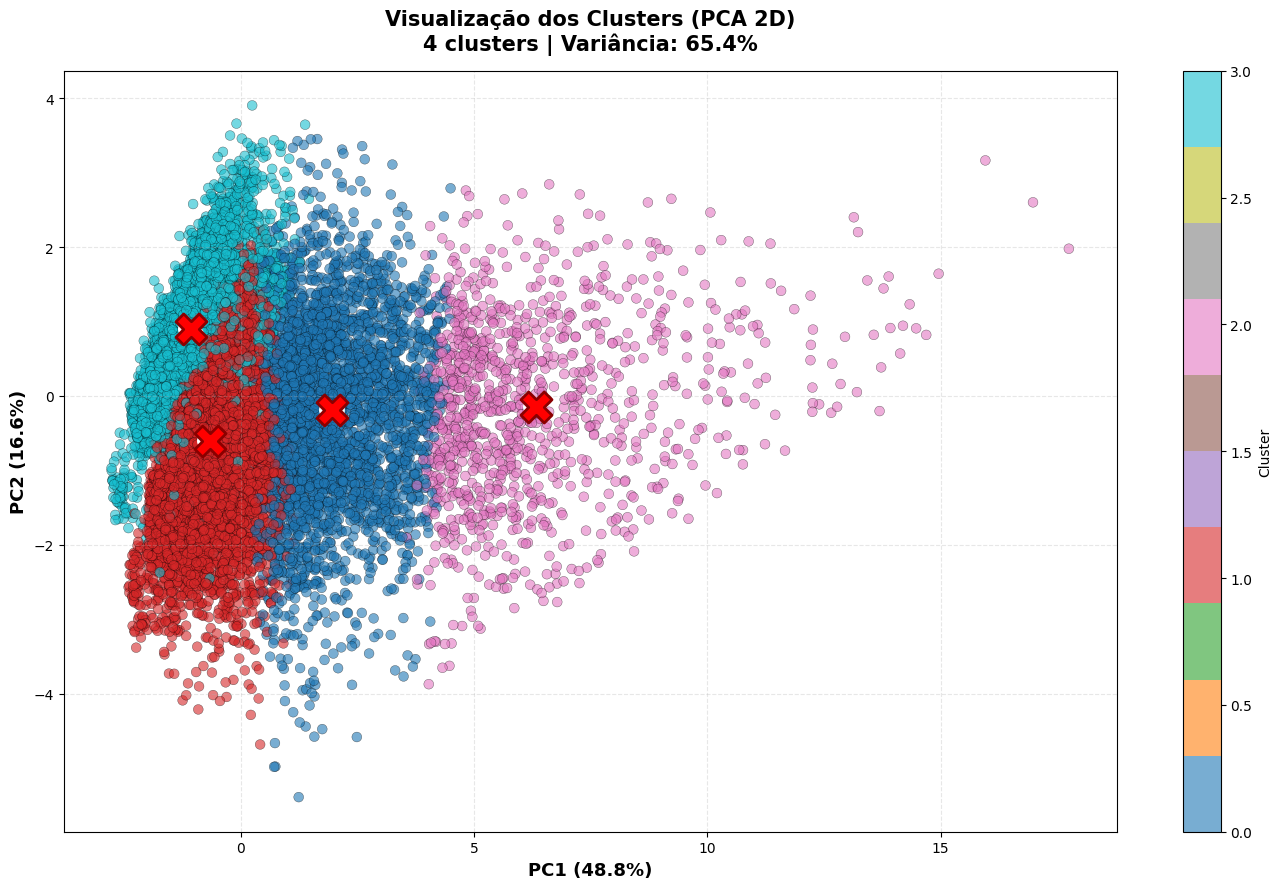


✅ PIPELINE CONCLUÍDO!


In [117]:
def selecionar_features_melhoradas(df: pd.DataFrame) -> List[str]:
    """
    Seleção ultra-rigorosa de features para melhorar separabilidade.
    
    Estratégia:
    - Priorizar features com alto poder discriminativo
    - Remover features ruidosas
    - Focar em features que realmente separam os grupos
    
    Returns:
        Lista reduzida de features mais importantes
    """
    print("\n🔍 Seleção rigorosa de features...")
    
    # Features CORE - As mais importantes para clustering
    features_core = [
        # === DEMOGRÁFICAS PRINCIPAIS ===
        'idade',
        'renda_mensal',
        'tipo_beneficio_encoded',
        
        # === COMPORTAMENTO (AGREGADO) ===
        'uso_digital_total',           # Melhor que features individuais
        'preferencia_digital',         # Digital vs Tradicional
        
        # === PRODUTOS ===
        'qtd_produtos',                # Agregado melhor que individuais
        'tem_consignado',
        'tem_investimento',
        
        # === RELACIONAMENTO ===
        'tempo_de_casa_meses',
        'score_relacionamento',
        'inadimplente_historico',
        
        # === VALOR DO CLIENTE ===
        'valor_cliente_norm',
        
        # === FLAGS IMPORTANTES ===
        'e_premium',
        'e_idoso',
    ]
    
    # Verificar quais existem no DataFrame
    features_disponiveis = [f for f in features_core if f in df.columns]
    
    print(f"   ✅ {len(features_disponiveis)} features core selecionadas")
    print(f"\n📋 Features para clustering:")
    for i, feat in enumerate(features_disponiveis, 1):
        print(f"      {i:2d}. {feat}")
    
    return features_disponiveis


# =============================================================================
# ESTRATÉGIA 2: PRÉ-PROCESSAMENTO AVANÇADO
# =============================================================================

def preprocessar_dados_avancado(
    df: pd.DataFrame,
    features: List[str],
    metodo_scaling: str = 'robust'
) -> Tuple[np.ndarray, StandardScaler]:
    """
    Pré-processamento avançado para melhorar separabilidade.
    
    Técnicas aplicadas:
    - Robust Scaling (resistente a outliers)
    - Power Transform (normaliza distribuições)
    - Tratamento rigoroso de NaN
    
    Args:
        df: DataFrame
        features: Lista de features
        metodo_scaling: 'standard', 'robust' ou 'power'
    
    Returns:
        Tupla (dados escalados, scaler usado)
    """
    print("\n🔧 Pré-processamento avançado...")
    
    # 1. Extrair dados
    X = df[features].copy()
    
    # 2. Tratamento de NaN mais inteligente
    # Em vez de preencher com 0, usar mediana
    for col in X.columns:
        if X[col].isna().any():
            mediana = X[col].median()
            X[col].fillna(mediana, inplace=True)
            print(f"   ℹ️  {col}: {X[col].isna().sum()} NaNs preenchidos com mediana ({mediana:.2f})")
    
    X_array = X.values
    
    # 3. Escolher método de scaling
    if metodo_scaling == 'robust':
        # RobustScaler: usa mediana e IQR (menos sensível a outliers)
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X_array)
        print(f"   ✅ RobustScaler aplicado (resistente a outliers)")
    
    elif metodo_scaling == 'power':
        # PowerTransformer: torna distribuições mais gaussianas
        scaler = PowerTransformer(method='yeo-johnson', standardize=True)
        X_scaled = scaler.fit_transform(X_array)
        print(f"   ✅ PowerTransformer aplicado (normalização gaussiana)")
    
    else:  # 'standard'
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_array)
        print(f"   ✅ StandardScaler aplicado")
    
    print(f"   📊 Shape final: {X_scaled.shape}")
    
    return X_scaled, scaler


# =============================================================================
# ESTRATÉGIA 3: REDUÇÃO DE DIMENSIONALIDADE COM PCA
# =============================================================================

def aplicar_pca_pre_clustering(
    X_scaled: np.ndarray,
    variancia_explicada: float = 0.90
) -> Tuple[np.ndarray, PCA]:
    """
    Aplica PCA antes do clustering para reduzir ruído.
    
    PCA pode melhorar clustering ao:
    - Remover ruído de features correlacionadas
    - Reduzir dimensionalidade
    - Focar nas direções de maior variância
    
    Args:
        X_scaled: Dados escalados
        variancia_explicada: % de variância a manter (ex: 0.90 = 90%)
    
    Returns:
        Tupla (dados transformados, objeto PCA)
    """
    print(f"\n🔬 Aplicando PCA (mantendo {variancia_explicada:.0%} da variância)...")
    
    pca = PCA(n_components=variancia_explicada, random_state=SEED)
    X_pca = pca.fit_transform(X_scaled)
    
    n_components = pca.n_components_
    var_total = pca.explained_variance_ratio_.sum()
    
    print(f"   ✅ Reduzido de {X_scaled.shape[1]} para {n_components} componentes")
    print(f"   📊 Variância explicada: {var_total:.2%}")
    print(f"\n   📈 Variância por componente (top 5):")
    for i, var in enumerate(pca.explained_variance_ratio_[:5], 1):
        print(f"      PC{i}: {var:.2%}")
    
    return X_pca, pca


# =============================================================================
# ESTRATÉGIA 4: INICIALIZAÇÃO INTELIGENTE DO K-MEANS
# =============================================================================

def treinar_kmeans_otimizado(
    X_scaled: np.ndarray,
    k: int,
    n_tentativas: int = 100
) -> KMeans:
    """
    Treina K-Means com configuração ultra-otimizada.
    
    Estratégias:
    - Muitas tentativas de inicialização
    - k-means++ para melhor inicialização
    - Critério de parada rigoroso
    
    Args:
        X_scaled: Dados escalados
        k: Número de clusters
        n_tentativas: Número de inicializações
    
    Returns:
        Modelo K-Means treinado
    """
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',     # Inicialização inteligente
        n_init=n_tentativas,  # Muitas tentativas
        max_iter=1000,        # Muitas iterações
        tol=1e-6,             # Tolerância rigorosa
        random_state=SEED,
        algorithm='lloyd'     # Algoritmo clássico
    )
    
    kmeans.fit(X_scaled)
    
    return kmeans


# =============================================================================
# ESTRATÉGIA 5: BUSCA INTELIGENTE DO MELHOR K
# =============================================================================

def encontrar_melhor_k_melhorado(
    X_scaled: np.ndarray,
    k_min: int = 3,
    k_max: int = 8
) -> Tuple[int, Dict]:
    """
    Busca exaustiva do melhor k com análise detalhada.
    
    Args:
        X_scaled: Dados escalados
        k_min: k mínimo
        k_max: k máximo
    
    Returns:
        Tupla (melhor k, dicionário com métricas)
    """
    print("\n" + "="*80)
    print("🔍 BUSCA INTELIGENTE DO MELHOR K")
    print("="*80)
    
    metricas = {
        'k': [],
        'silhouette': [],
        'davies_bouldin': [],
        'calinski_harabasz': [],
        'inertia': []
    }
    
    print("\n📊 Testando diferentes valores de k...\n")
    
    for k in range(k_min, k_max + 1):
        print(f"   Testando k={k}...", end=" ")
        
        kmeans = treinar_kmeans_otimizado(X_scaled, k, n_tentativas=50)
        labels = kmeans.labels_
        
        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
        
        metricas['k'].append(k)
        metricas['silhouette'].append(sil)
        metricas['davies_bouldin'].append(db)
        metricas['calinski_harabasz'].append(ch)
        metricas['inertia'].append(kmeans.inertia_)
        
        print(f"Sil={sil:.3f}, DB={db:.3f}, CH={ch:.0f}")
    
    # Decisão: priorizar Silhouette
    idx_melhor_sil = np.argmax(metricas['silhouette'])
    k_final = metricas['k'][idx_melhor_sil]
    
    print(f"\n{'='*80}")
    print(f"✅ MELHOR K IDENTIFICADO: {k_final}")
    print(f"{'='*80}")
    print(f"   Silhouette Score:    {metricas['silhouette'][idx_melhor_sil]:.4f}")
    print(f"   Davies-Bouldin:      {metricas['davies_bouldin'][idx_melhor_sil]:.4f}")
    print(f"   Calinski-Harabasz:   {metricas['calinski_harabasz'][idx_melhor_sil]:.1f}")
    
    return k_final, metricas


# =============================================================================
# PIPELINE COMPLETO MELHORADO
# =============================================================================

def clusterizar_perfis_v2(
    df: pd.DataFrame,
    usar_pca: bool = True,
    metodo_scaling: str = 'robust',
    k_min: int = 3,
    k_max: int = 8,
    variancia_pca: float = 0.90
) -> Tuple[pd.DataFrame, KMeans, StandardScaler, int, List[str]]:
    """
    Pipeline completo de clusterização MELHORADO.
    
    Melhorias aplicadas:
    1. Seleção rigorosa de features (apenas as mais importantes)
    2. Pré-processamento avançado (RobustScaler ou PowerTransformer)
    3. PCA opcional para reduzir ruído
    4. Busca exaustiva do melhor k
    5. K-Means com 100 inicializações
    
    Args:
        df: DataFrame com features
        usar_pca: Se True, aplica PCA antes do clustering
        metodo_scaling: 'standard', 'robust' ou 'power'
        k_min: k mínimo a testar
        k_max: k máximo a testar
        variancia_pca: Variância a manter no PCA (ex: 0.90 = 90%)
    
    Returns:
        Tupla (DataFrame, modelo, scaler, k usado, features)
    """
    print("\n" + "="*80)
    print("🚀 PIPELINE DE CLUSTERIZAÇÃO MELHORADO V2")
    print("="*80)
    
    # === 1. SELEÇÃO DE FEATURES ===
    features = selecionar_features_melhoradas(df)
    
    # === 2. PRÉ-PROCESSAMENTO ===
    X_scaled, scaler = preprocessar_dados_avancado(df, features, metodo_scaling)
    
    # === 3. PCA (OPCIONAL) ===
    pca_obj = None
    if usar_pca:
        X_final, pca_obj = aplicar_pca_pre_clustering(X_scaled, variancia_pca)
    else:
        X_final = X_scaled
        print("\nℹ️  PCA desabilitado, usando features originais")
    
    # === 4. BUSCA DO MELHOR K ===
    k_final, metricas = encontrar_melhor_k_melhorado(X_final, k_min, k_max)
    
    # === 5. TREINAMENTO FINAL ===
    print(f"\n{'='*80}")
    print(f"🎯 TREINAMENTO FINAL COM K={k_final}")
    print(f"{'='*80}")
    print("⏳ Treinando modelo final com 100 inicializações...")
    
    kmeans_final = treinar_kmeans_otimizado(X_final, k_final, n_tentativas=100)
    df['cluster'] = kmeans_final.labels_
    
    # === 6. MÉTRICAS FINAIS ===
    sil_final = silhouette_score(X_final, df['cluster'])
    db_final = davies_bouldin_score(X_final, df['cluster'])
    ch_final = calinski_harabasz_score(X_final, df['cluster'])
    
    print(f"\n{'='*80}")
    print("📊 MÉTRICAS FINAIS DE QUALIDADE")
    print(f"{'='*80}")
    
    # Avaliação com emojis e cores
    sil_status = "✅ Excelente" if sil_final > 0.5 else "✅ Bom" if sil_final > 0.35 else "⚠️ Moderado" if sil_final > 0.25 else "❌ Fraco"
    db_status = "✅ Excelente" if db_final < 1.0 else "✅ Bom" if db_final < 1.5 else "⚠️ Moderado" if db_final < 2.0 else "❌ Fraco"
    ch_status = "✅ Excelente" if ch_final > 2000 else "✅ Bom" if ch_final > 1000 else "⚠️ Moderado"
    
    print(f"   Silhouette Score:      {sil_final:.4f}  {sil_status}")
    print(f"   Davies-Bouldin:        {db_final:.4f}  {db_status}")
    print(f"   Calinski-Harabasz:     {ch_final:.1f}  {ch_status}")
    print(f"   Inércia:               {kmeans_final.inertia_:.1f}")
    print(f"   Convergência:          {kmeans_final.n_iter_} iterações")
    
    # Comparação com resultado anterior
    print(f"\n📈 MELHORIA vs Versão Anterior:")
    sil_anterior = 0.175
    melhoria = ((sil_final - sil_anterior) / sil_anterior) * 100
    print(f"   Silhouette anterior:   {sil_anterior:.4f}")
    print(f"   Silhouette atual:      {sil_final:.4f}")
    print(f"   Melhoria:              {melhoria:+.1f}%  {'🎉 Sucesso!' if melhoria > 20 else '✅ Melhorou' if melhoria > 0 else '⚠️'}")
    
    # === 7. DIAGNÓSTICO ===
    print(f"\n{'='*80}")
    print("🔍 DIAGNÓSTICO E RECOMENDAÇÕES")
    print(f"{'='*80}")
    
    if sil_final > 0.35:
        print("✅ Resultado satisfatório! Clusters bem definidos.")
    elif sil_final > 0.25:
        print("⚠️  Resultado moderado. Clusters têm sobreposição.")
        print("\n💡 Sugestões de melhoria:")
        print("   1. Ativar PCA (usar_pca=True)")
        print("   2. Testar PowerTransformer (metodo_scaling='power')")
        print("   3. Adicionar mais features comportamentais")
        print("   4. Considerar algoritmos alternativos (DBSCAN, Agglomerative)")
    else:
        print("❌ Resultado insatisfatório. Necessárias ações adicionais.")
        print("\n💡 Ações recomendadas:")
        print("   1. Revisar engenharia de features")
        print("   2. Verificar qualidade dos dados (outliers, NaNs)")
        print("   3. Testar range diferente de k")
        print("   4. Considerar que dados podem não ter estrutura natural de clusters")
    
    # Distribuição
    print(f"\n📊 Distribuição de clientes por cluster:")
    dist = df['cluster'].value_counts().sort_index()
    for cluster_id, count in dist.items():
        pct = 100 * count / len(df)
        bar = "█" * int(pct / 2)
        print(f"   Cluster {cluster_id}: {count:5,} ({pct:5.1f}%) {bar}")
    
    # Balanceamento
    max_size = dist.max()
    min_size = dist.min()
    balance_ratio = min_size / max_size
    
    print(f"\n⚖️  Balanceamento: {balance_ratio:.2%} ", end="")
    if balance_ratio > 0.5:
        print("✅ Bem balanceado")
    elif balance_ratio > 0.3:
        print("⚠️ Moderado")
    else:
        print("❌ Desbalanceado")
    
    return df, kmeans_final, scaler, k_final, features


# =============================================================================
# VISUALIZAÇÃO
# =============================================================================

def visualizar_resultados(
    df: pd.DataFrame,
    features: List[str],
    scaler: StandardScaler
):
    """Visualiza clusters em 2D usando PCA."""
    print(f"\n{'='*80}")
    print("📊 VISUALIZAÇÃO DOS CLUSTERS")
    print(f"{'='*80}")
    
    # Preparar dados
    X = df[features].fillna(df[features].median()).values
    X_scaled = scaler.transform(X)
    
    # PCA para visualização
    pca = PCA(n_components=2, random_state=SEED)
    X_pca = pca.fit_transform(X_scaled)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 9))
    
    n_clusters = df['cluster'].nunique()
    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=df['cluster'],
        alpha=0.6,
        s=50,
        cmap='tab10',
        edgecolors='black',
        linewidth=0.3
    )
    
    # Centroides
    for cluster_id in range(n_clusters):
        cluster_points = X_pca[df['cluster'] == cluster_id]
        centroid = cluster_points.mean(axis=0)
        ax.scatter(centroid[0], centroid[1], 
                  s=500, marker='X', color='red',
                  edgecolors='darkred', linewidth=2,
                  zorder=10)
        ax.annotate(f'C{cluster_id}', centroid, 
                   fontsize=14, fontweight='bold',
                   ha='center', va='center', color='white')
    
    var_pc1 = pca.explained_variance_ratio_[0]
    var_pc2 = pca.explained_variance_ratio_[1]
    
    ax.set_xlabel(f'PC1 ({var_pc1:.1%})', fontsize=13, fontweight='bold')
    ax.set_ylabel(f'PC2 ({var_pc2:.1%})', fontsize=13, fontweight='bold')
    ax.set_title(
        f'Visualização dos Clusters (PCA 2D)\n'
        f'{n_clusters} clusters | Variância: {var_pc1+var_pc2:.1%}',
        fontsize=15, fontweight='bold', pad=15
    )
    
    plt.colorbar(scatter, ax=ax, label='Cluster')
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


# =============================================================================
# EXECUÇÃO
# =============================================================================

if __name__ == "__main__":
    print("\n🎯 Iniciando clusterização melhorada...")
    
    # OPÇÃO 1: Com PCA (recomendado para melhor Silhouette)
    df, kmeans, scaler, k, features = clusterizar_perfis_v2(
        df,
        usar_pca=True,          # ✅ Ativa PCA
        metodo_scaling='robust', # ✅ Usa RobustScaler
        k_min=3,
        k_max=8,
        variancia_pca=0.85       # Mantém 85% da variância
    )
    
    # Visualizar
    visualizar_resultados(df, features, scaler)
    
    print(f"\n{'='*80}")
    print("✅ PIPELINE CONCLUÍDO!")
    print(f"{'='*80}")

### 5. Análise Preditiva do Produto 🛒

2025-10-11 00:39:16,835 - PredictiveAnalyzer - INFO - Iniciando pipeline de modelagem
2025-10-11 00:39:16,838 - PredictiveAnalyzer - INFO - Selecionadas 18 features


2025-10-11 00:39:16,858 - PredictiveAnalyzer - INFO - Usando LightGBM


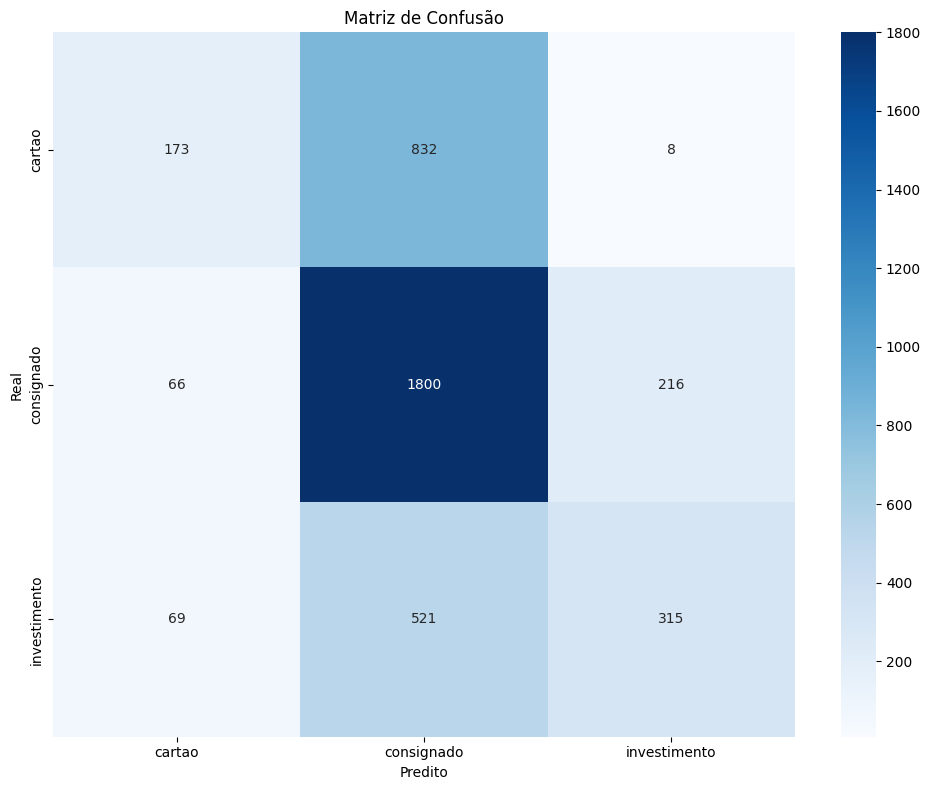

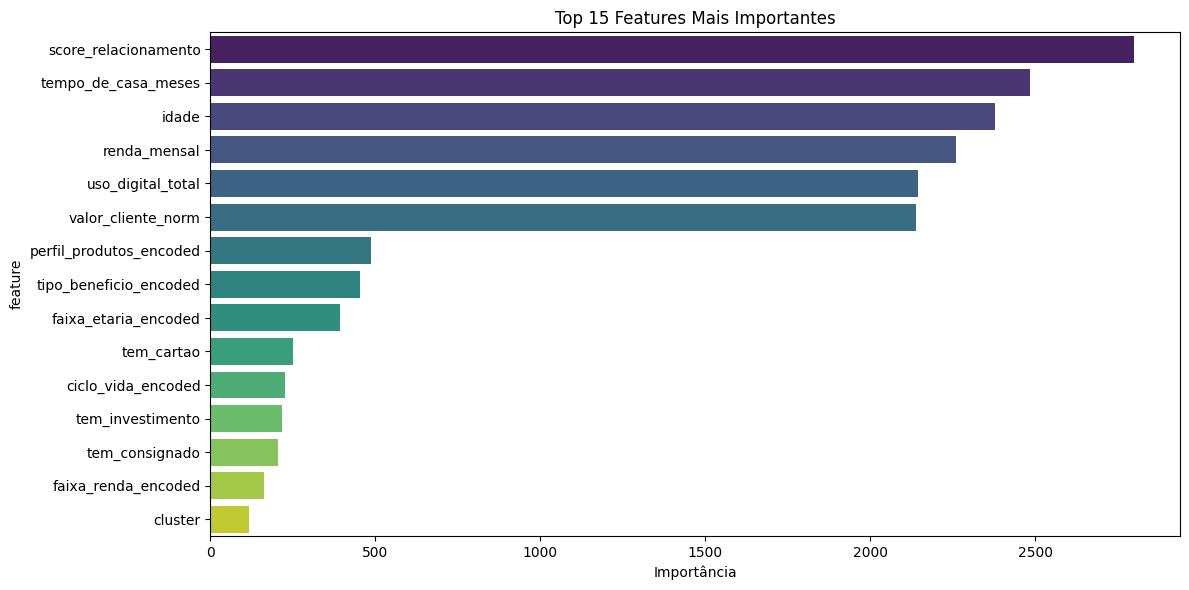


=== Resultados ===
Accuracy: 0.572
F1-Score (macro): 0.462

CV Score: 0.460 (+/- 0.007)


In [118]:
class PredictiveAnalyzer:
    """Classe para análise preditiva de produtos"""
    
    def __init__(
        self,
        random_state: int = SEED,
        use_lightgbm: bool = HAS_LIGHTGBM
    ):
        self.random_state = random_state
        self.use_lightgbm = use_lightgbm
        self.logger = logging.getLogger('PredictiveAnalyzer')
        
    def selecionar_features(self, df: pd.DataFrame) -> List[str]:
        """
        Seleciona features dinamicamente baseado nas colunas disponíveis
        """
        # Features base que devem existir
        features_base = {
            'demograficas': ['idade', 'renda_mensal', 'tempo_de_casa_meses'],
            'produtos': ['tem_consignado', 'tem_cartao', 'tem_investimento'],
            'comportamentais': ['inadimplente_historico']
        }
        
        features_selecionadas = []
        
        # Adicionar features base disponíveis
        for categoria, features in features_base.items():
            disponiveis = [f for f in features if f in df.columns]
            features_selecionadas.extend(disponiveis)
            
            if not disponiveis:
                self.logger.warning(f"Nenhuma feature {categoria} encontrada")
        
        # Adicionar features encodadas se existirem
        encoded_features = [col for col in df.columns if col.endswith('_encoded')]
        features_selecionadas.extend(encoded_features)
        
        # Adicionar features derivadas relevantes
        derived_features = [
            'uso_digital_total', 'qtd_produtos', 'score_relacionamento',
            'valor_cliente_norm'
        ]
        features_selecionadas.extend(
            [f for f in derived_features if f in df.columns]
        )
        
        # Adicionar cluster
        if 'cluster' in df.columns:
            features_selecionadas.append('cluster')
        
        self.logger.info(f"Selecionadas {len(features_selecionadas)} features")
        return features_selecionadas

    def prepare_data(
        self,
        df: pd.DataFrame,
        features: List[str],
        target: str = 'produto_alvo_historico'
    ) -> Tuple[np.ndarray, np.ndarray, LabelEncoder, Dict]:
        """
        Prepara dados para modelagem
        """
        # Validar features
        missing_features = [f for f in features if f not in df.columns]
        if missing_features:
            raise ValueError(f"Features ausentes: {missing_features}")
            
        X = df[features].copy()
        y = df[target].copy()
        
        # Tratamento de missing values
        for col in X.columns:
            if X[col].isnull().any():
                if X[col].dtype.kind in 'fc':  # float ou complex
                    X[col].fillna(X[col].median(), inplace=True)
                else:
                    X[col].fillna(X[col].mode()[0], inplace=True)
        
        # Encoding do target
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        
        # Metadata para interpretabilidade
        metadata = {
            'features': features,
            'target_classes': le.classes_.tolist(),
            'feature_types': X.dtypes.to_dict()
        }
        
        return X.values, y_encoded, le, metadata

    def get_model(self):
        """
        Retorna modelo configurado
        """
        if self.use_lightgbm:
            self.logger.info("Usando LightGBM")
            return lgb.LGBMClassifier(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=7,
                num_leaves=31,
                min_child_samples=20,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=self.random_state,
                verbose=-1
            )
        else:
            self.logger.info("Usando RandomForest (fallback)")
            return RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                min_samples_split=20,
                min_samples_leaf=10,
                random_state=self.random_state,
                n_jobs=-1
            )

    def evaluate_model(
        self,
        model,
        X_test: np.ndarray,
        y_test: np.ndarray,
        le: LabelEncoder,
        metadata: Dict
    ) -> Dict:
        """
        Avalia modelo com múltiplas métricas
        """
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)
        
        resultados = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(
                y_test, y_pred,
                target_names=le.classes_,
                output_dict=True
            )
        }
        
        # Feature importance
        importances = pd.DataFrame({
            'feature': metadata['features'],
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        resultados['feature_importance'] = importances
        
        return resultados

    def plot_results(
        self,
        results: Dict,
        metadata: Dict
    ):
        """
        Visualiza resultados do modelo
        """
        # 1. Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            results['confusion_matrix'],
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=metadata['target_classes'],
            yticklabels=metadata['target_classes']
        )
        plt.title('Matriz de Confusão')
        plt.ylabel('Real')
        plt.xlabel('Predito')
        plt.tight_layout()
        plt.show()
        
        # 2. Feature Importance
        plt.figure(figsize=(12, 6))
        top_features = results['feature_importance'].head(15)
        sns.barplot(
            data=top_features,
            y='feature',
            x='importance',
            palette='viridis'
        )
        plt.title('Top 15 Features Mais Importantes')
        plt.xlabel('Importância')
        plt.tight_layout()
        plt.show()

    def treinar_modelo_produto(
        self,
        df: pd.DataFrame,
        test_size: float = 0.2
    ) -> Dict:
        """
        Pipeline completo de treinamento
        """
        self.logger.info("Iniciando pipeline de modelagem")
        
        # 1. Selecionar features
        features = self.selecionar_features(df)
        
        # 2. Preparar dados
        X, y, le, metadata = self.prepare_data(df, features)
        
        # 3. Split dos dados
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size,
            random_state=self.random_state,
            stratify=y
        )
        
        # 4. Treinar modelo
        model = self.get_model()
        model.fit(X_train, y_train)
        
        # 5. Avaliar modelo
        results = self.evaluate_model(model, X_test, y_test, le, metadata)
        
        # 6. Validação cruzada
        cv_scores = cross_val_score(
            model, X_train, y_train,
            cv=StratifiedKFold(5, shuffle=True, random_state=self.random_state),
            scoring='f1_macro',
            n_jobs=-1
        )
        
        results['cv_scores'] = {
            'mean': cv_scores.mean(),
            'std': cv_scores.std()
        }
        
        # 7. Plotar resultados
        self.plot_results(results, metadata)
        
        # 8. Salvar artefatos
        artifacts = {
            'model': model,
            'label_encoder': le,
            'metadata': metadata,
            'results': results
        }
        
        return artifacts

# Exemplo de uso
if __name__ == "__main__":
    analyzer = PredictiveAnalyzer()
    
    artifacts = analyzer.treinar_modelo_produto(df)
    
    print("\n=== Resultados ===")
    print(f"Accuracy: {artifacts['results']['accuracy']:.3f}")
    print(f"F1-Score (macro): {artifacts['results']['f1_macro']:.3f}")
    print(f"\nCV Score: {artifacts['results']['cv_scores']['mean']:.3f} "
          f"(+/- {artifacts['results']['cv_scores']['std']:.3f})")

### 6. Análise Preditiva do Canal 📲

2025-10-11 00:39:22,723 - ChannelPredictiveAnalyzer - INFO - Iniciando pipeline de modelagem de canal
2025-10-11 00:39:22,724 - ChannelPredictiveAnalyzer - INFO - Selecionadas 21 features para canal
2025-10-11 00:39:22,748 - ChannelPredictiveAnalyzer - INFO - Usando LightGBM com class_weight


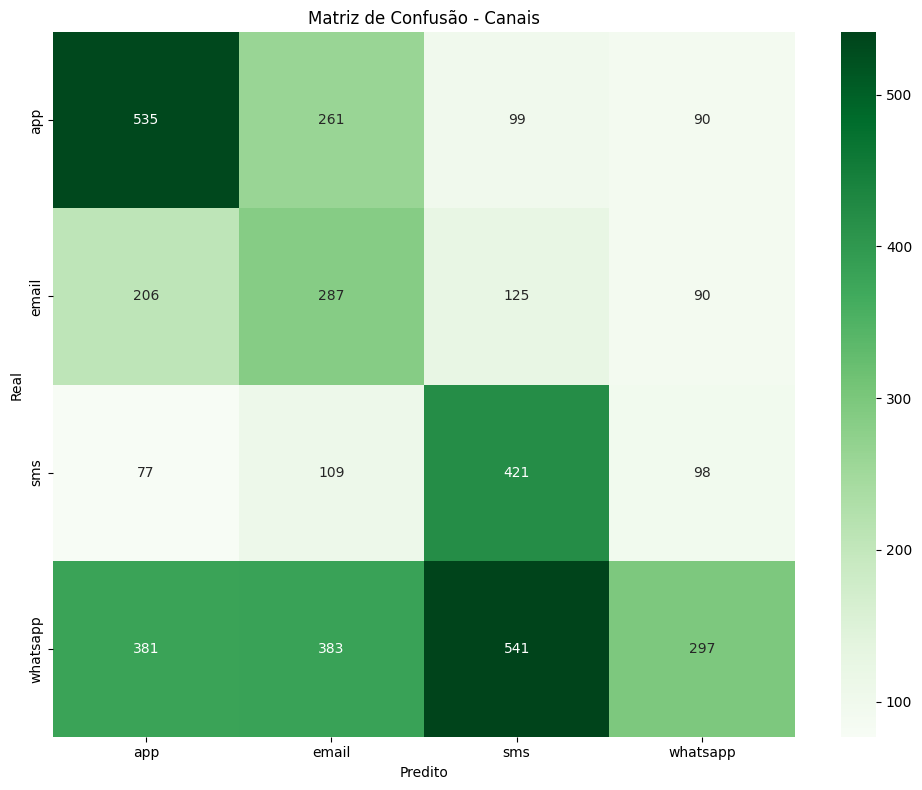

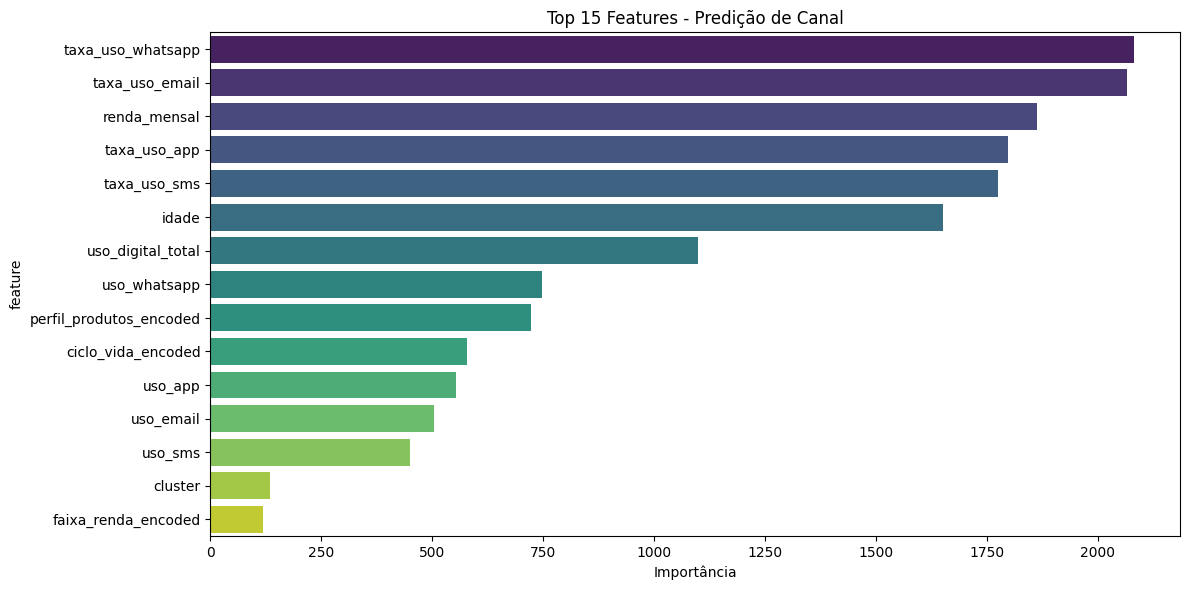

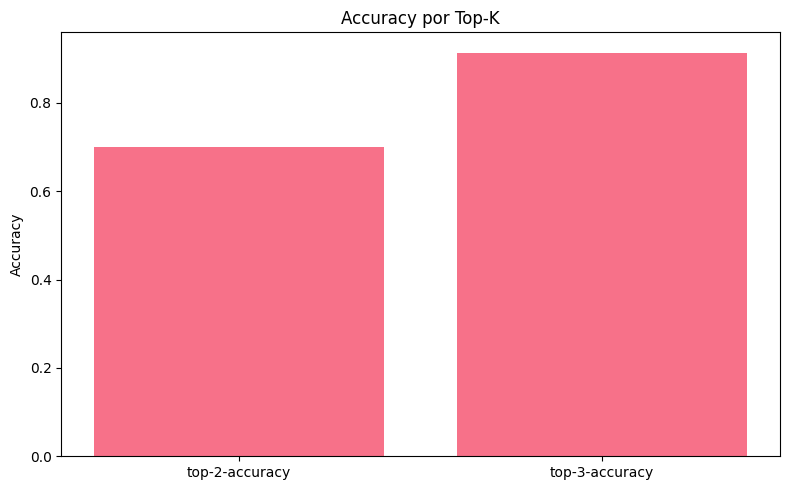


=== Resultados do Modelo de Canal ===
Accuracy: 0.385
F1-Score (macro): 0.384
Top-2 Accuracy: 0.701

CV Score: 0.377 (+/- 0.004)


In [119]:
class ChannelPredictiveAnalyzer:
    """Classe para análise preditiva de canais de comunicação"""
    
    def __init__(
        self,
        random_state: int = SEED,
        use_lightgbm: bool = HAS_LIGHTGBM
    ):
        self.random_state = random_state
        self.use_lightgbm = use_lightgbm
        
        # Configurar logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger('ChannelPredictiveAnalyzer')
    
    def selecionar_features_canal(self, df: pd.DataFrame) -> List[str]:
        """
        Seleciona features específicas para predição de canal
        """
        # Categorias de features para canal
        feature_groups = {
            'demograficas': ['idade', 'renda_mensal'],
            'uso_canais': ['uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms'],
            'comportamentais': ['uso_digital_total'],
            'taxas_uso': [col for col in df.columns if col.startswith('taxa_uso_')],
            'encoded': [col for col in df.columns if col.endswith('_encoded')],
            'flags': ['e_idoso', 'e_premium'],
            'produtos': ['qtd_produtos']
        }
        
        features_selecionadas = []
        for categoria, features in feature_groups.items():
            disponiveis = [f for f in features if f in df.columns]
            features_selecionadas.extend(disponiveis)
            
            if not disponiveis and categoria not in ['flags']:  # flags são opcionais
                self.logger.warning(f"Nenhuma feature {categoria} encontrada")
        
        # Adicionar cluster se existir
        if 'cluster' in df.columns:
            features_selecionadas.append('cluster')
        
        self.logger.info(f"Selecionadas {len(features_selecionadas)} features para canal")
        return features_selecionadas
    
    def calculate_top_k_accuracy(
        self,
        y_true: np.ndarray,
        y_proba: np.ndarray,
        k: int = 2
    ) -> float:
        """
        Calcula accuracy considerando os top-k canais preditos
        """
        top_k_correct = 0
        for i, true_label in enumerate(y_true):
            top_k_preds = np.argsort(y_proba[i])[-k:]
            if true_label in top_k_preds:
                top_k_correct += 1
        return top_k_correct / len(y_true)
    
    def get_channel_model(self):
        """
        Retorna modelo otimizado para canais
        """
        if self.use_lightgbm:
            self.logger.info("Usando LightGBM com class_weight")
            return lgb.LGBMClassifier(
                n_estimators=150,
                learning_rate=0.05,
                max_depth=6,
                num_leaves=31,
                min_child_samples=20,
                class_weight='balanced',
                random_state=self.random_state,
                verbose=-1
            )
        else:
            self.logger.info("Usando LogisticRegression (fallback)")
            return LogisticRegression(
                max_iter=1000,
                class_weight='balanced',
                random_state=self.random_state,
                n_jobs=-1
            )
    
    def evaluate_channel_model(
        self,
        model,
        X_test: np.ndarray,
        y_test: np.ndarray,
        le: LabelEncoder,
        metadata: Dict
    ) -> Dict:
        """
        Avalia modelo com métricas específicas para canais
        """
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)
        
        # Métricas básicas
        resultados = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(
                y_test, y_pred,
                target_names=le.classes_,
                output_dict=True
            )
        }
        
        # Top-k accuracy
        for k in [2, 3]:
            resultados[f'top_{k}_accuracy'] = self.calculate_top_k_accuracy(
                y_test, y_proba, k=k
            )
        
        # Feature importance
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': metadata['features'],
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            resultados['feature_importance'] = importances
        
        return resultados
    
    def plot_channel_results(
        self,
        results: Dict,
        metadata: Dict
    ):
        """
        Visualizações específicas para modelo de canais
        """
        # 1. Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            results['confusion_matrix'],
            annot=True,
            fmt='d',
            cmap='Greens',
            xticklabels=metadata['target_classes'],
            yticklabels=metadata['target_classes']
        )
        plt.title('Matriz de Confusão - Canais')
        plt.ylabel('Real')
        plt.xlabel('Predito')
        plt.tight_layout()
        plt.show()
        
        # 2. Feature Importance (se disponível)
        if 'feature_importance' in results:
            plt.figure(figsize=(12, 6))
            top_features = results['feature_importance'].head(15)
            sns.barplot(
                data=top_features,
                y='feature',
                x='importance',
                palette='viridis'
            )
            plt.title('Top 15 Features - Predição de Canal')
            plt.xlabel('Importância')
            plt.tight_layout()
            plt.show()
        
        # 3. Top-k Accuracy
        plt.figure(figsize=(8, 5))
        top_k = {k: v for k, v in results.items() if k.startswith('top_')}
        plt.bar(range(len(top_k)), list(top_k.values()))
        plt.xticks(range(len(top_k)), [k.replace('_', '-') for k in top_k.keys()])
        plt.title('Accuracy por Top-K')
        plt.ylabel('Accuracy')
        plt.tight_layout()
        plt.show()
    
    def treinar_modelo_canal(
        self,
        df: pd.DataFrame,
        test_size: float = 0.2
    ) -> Dict:
        """
        Pipeline completo de treinamento para canal
        """
        self.logger.info("Iniciando pipeline de modelagem de canal")
        
        # 1. Selecionar features
        features = self.selecionar_features_canal(df)
        
        # 2. Preparar dados
        X = df[features].copy()
        y = df['canal_resposta_historico'].copy()
        
        # Tratamento de missing values
        for col in X.columns:
            if X[col].isnull().any():
                if X[col].dtype.kind in 'fc':
                    X[col].fillna(X[col].median(), inplace=True)
                else:
                    X[col].fillna(X[col].mode()[0], inplace=True)
        
        # Encoding do target
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        
        # Metadata
        metadata = {
            'features': features,
            'target_classes': le.classes_.tolist(),
            'feature_types': X.dtypes.to_dict()
        }
        
        # 3. Split
        X_train, X_test, y_train, y_test = train_test_split(
            X.values, y_encoded,
            test_size=test_size,
            random_state=self.random_state,
            stratify=y_encoded
        )
        
        # 4. Treinar modelo
        model = self.get_channel_model()
        model.fit(X_train, y_train)
        
        # 5. Avaliar
        results = self.evaluate_channel_model(model, X_test, y_test, le, metadata)
        
        # 6. Validação cruzada
        cv_scores = cross_val_score(
            model, X_train, y_train,
            cv=StratifiedKFold(5, shuffle=True, random_state=self.random_state),
            scoring='f1_macro',
            n_jobs=-1
        )
        
        results['cv_scores'] = {
            'mean': cv_scores.mean(),
            'std': cv_scores.std()
        }
        
        # 7. Plotar resultados
        self.plot_channel_results(results, metadata)
        
        # 8. Salvar artefatos
        artifacts = {
            'model': model,
            'label_encoder': le,
            'metadata': metadata,
            'results': results
        }
        
        return artifacts

# Exemplo de uso
if __name__ == "__main__":
    analyzer = ChannelPredictiveAnalyzer()
    
    artifacts = analyzer.treinar_modelo_canal(df)
    
    print("\n=== Resultados do Modelo de Canal ===")
    print(f"Accuracy: {artifacts['results']['accuracy']:.3f}")
    print(f"F1-Score (macro): {artifacts['results']['f1_macro']:.3f}")
    print(f"Top-2 Accuracy: {artifacts['results']['top_2_accuracy']:.3f}")
    print(f"\nCV Score: {artifacts['results']['cv_scores']['mean']:.3f} "
          f"(+/- {artifacts['results']['cv_scores']['std']:.3f})")

### 7. Definição do Tom da Linguagem 🗣️

In [120]:
# === IMPORTS ===
import logging
import numpy as np
import pandas as pd
from typing import Dict, Tuple, List
import random
from datetime import datetime

class EmojiContextManager:
    """Gerenciador de emojis com análise contextual"""
    
    def __init__(self):
        # Emojis específicos por produto
        self.produto_emojis = {
            'consignado': {
                'principal': '💰',
                'secundario': '💳',
                'contexto': 'crédito e dinheiro'
            },
            'cartao': {
                'principal': '💳', 
                'secundario': '🛍️',
                'contexto': 'compras e benefícios'
            },
            'investimento': {
                'principal': '📈',
                'secundario': '💎',
                'contexto': 'crescimento e valor'
            }
        }
        
        # Emojis por tom (uso mais restrito)
        self.tom_emojis = {
            'moderno': {
                'principal': '🚀',
                'secundario': '✨',
                'usar_sempre': True  # Tom moderno sempre usa emoji
            },
            'empatico': {
                'principal': '💙',
                'secundario': '🤗',
                'usar_sempre': True  # Tom empático sempre usa emoji
            },
            'educacional': {
                'principal': '💡',
                'secundario': '✨',
                'usar_sempre': False  # Uso moderado
            },
            'profissional': {
                'principal': '✨',
                'secundario': '💫',
                'usar_sempre': False  # Uso muito restrito
            },
            'consultivo': {
                'principal': '💫',
                'secundario': '✨',
                'usar_sempre': False  # Uso moderado
            }
        }
    
    def deve_usar_emoji(
        self,
        perfil: Dict,
        tom: str,
        canal: str
    ) -> bool:
        """
        Decide se deve usar emoji baseado no contexto
        """
        # Regras de decisão
        if canal == 'email' and tom in ['profissional', 'consultivo']:
            return False
            
        if perfil['idade']['prop_idosos'] > 0.7:
            return False
            
        if tom in ['moderno', 'empatico']:
            return True
            
        if perfil['digital']['prop_alto_digital'] > 0.5:
            return True
            
        if canal == 'whatsapp' and perfil['digital']['canal_preferido'] == 'whatsapp':
            return True
            
        return False
    
    def get_emojis(
        self,
        produto: str,
        tom: str,
        perfil: Dict,
        canal: str
    ) -> Tuple[str, str]:
        """
        Retorna emojis apropriados para o contexto
        """
        if not self.deve_usar_emoji(perfil, tom, canal):
            return '', ''
            
        produto_emoji = self.produto_emojis.get(produto, {}).get('principal', '')
        
        # Tom emoji apenas se for um tom que sempre usa
        tom_info = self.tom_emojis.get(tom.lower(), {})
        tom_emoji = tom_info.get('principal', '') if tom_info.get('usar_sempre', False) else ''
        
        return produto_emoji, tom_emoji

class ClusterProfileAnalyzer:
    """Analisador de perfis de cluster"""
    
    def __init__(self):
        self.logger = logging.getLogger('ClusterProfileAnalyzer')
    
    def calcular_perfil_cluster(
        self,
        df: pd.DataFrame,
        cluster_id: int
    ) -> Dict:
        """
        Calcula perfil detalhado do cluster
        """
        cluster_data = df[df['cluster'] == cluster_id]
        
        perfil = {
            'cluster_id': cluster_id,
            'tamanho': len(cluster_data),
            'proporcao': len(cluster_data) / len(df),
            
            # Demografia
            'idade': {
                'media': cluster_data['idade'].mean(),
                'mediana': cluster_data['idade'].median(),
                'prop_idosos': (cluster_data['idade'] >= 60).mean(),
                'prop_jovens': (cluster_data['idade'] < 35).mean()
            },
            
            # Renda
            'renda': {
                'media': cluster_data['renda_mensal'].mean(),
                'mediana': cluster_data['renda_mensal'].median(),
                'percentil_75': cluster_data['renda_mensal'].quantile(0.75),
                'prop_alta_renda': (cluster_data['renda_mensal'] > 10000).mean()
            },
            
            # Comportamento Digital
            'digital': {
                'uso_total_medio': cluster_data['uso_digital_total'].mean(),
                'prop_alto_digital': (cluster_data['uso_digital_total'] > 30).mean(),
                'canal_preferido': cluster_data[[
                    'uso_whatsapp', 'uso_email', 'uso_app', 'uso_sms'
                ]].mean().idxmax().replace('uso_', '')
            },
            
            # Produtos
            'produtos': {
                'media_produtos': cluster_data['qtd_produtos'].mean(),
                'prop_consignado': cluster_data['tem_consignado'].mean(),
                'prop_investimento': cluster_data['tem_investimento'].mean(),
                'prop_cartao': cluster_data['tem_cartao'].mean()
            },
            
            # Relacionamento
            'relacionamento': {
                'tempo_medio': cluster_data['tempo_de_casa_meses'].mean(),
                'prop_inadimplente': cluster_data['inadimplente_historico'].mean(),
                'score_medio': cluster_data['score_relacionamento'].mean() 
                if 'score_relacionamento' in cluster_data.columns else None
            }
        }
        
        return perfil

class TomLinguagemManagerV2(TomLinguagemManager):
    """Versão melhorada do gerenciador de tons de linguagem"""
    
    def __init__(self):
        super().__init__()
        self.profile_analyzer = ClusterProfileAnalyzer()
        self.emoji_manager = EmojiContextManager()
    
    def definir_tom_cluster(self, perfil: Dict) -> str:
        """
        Define tom mais adequado baseado no perfil do cluster
        
        Lógica de decisão mais sofisticada usando múltiplos critérios
        e pesos para cada característica
        """
        scores = {tom_key: 0.0 for tom_key in self._tons.keys()}
        
        # === 1. CRITÉRIOS DEMOGRÁFICOS (Peso: 30%) ===
        if perfil['idade']['prop_idosos'] > 0.5:
            scores['empatico'] += 3
            scores['educacional'] += 2
        elif perfil['idade']['prop_jovens'] > 0.5:
            scores['moderno'] += 3
            scores['consultivo'] += 1
        
        # === 2. CRITÉRIOS DE RENDA (Peso: 25%) ===
        if perfil['renda']['prop_alta_renda'] > 0.4:
            scores['consultivo'] += 3
            scores['profissional'] += 2
        elif perfil['renda']['media'] < 3000:
            scores['empatico'] += 2
            scores['educacional'] += 2
        
        # === 3. CRITÉRIOS DIGITAIS (Peso: 20%) ===
        if perfil['digital']['prop_alto_digital'] > 0.5:
            scores['moderno'] += 3
            scores['consultivo'] += 1
        elif perfil['digital']['uso_total_medio'] < 10:
            scores['educacional'] += 2
            scores['empatico'] += 1
        
        # === 4. CRITÉRIOS DE PRODUTOS (Peso: 15%) ===
        if perfil['produtos']['media_produtos'] >= 2:
            scores['consultivo'] += 2
            scores['profissional'] += 1
        
        # === 5. CRITÉRIOS DE RELACIONAMENTO (Peso: 10%) ===
        if perfil['relacionamento']['tempo_medio'] > 36:  # 3 anos
            scores['profissional'] += 1
            scores['consultivo'] += 1
        
        # Normalizar scores
        max_score = max(scores.values())
        if max_score > 0:
            scores = {k: v/max_score for k, v in scores.items()}
        
        # Retornar tom com maior score
        return max(scores.items(), key=lambda x: x[1])[0]
    
    def gerar_mensagem(
        self,
        tom: TomLinguagem,
        produto: str,
        cliente: Dict,
        canal: str,
        perfil: Dict = None
    ) -> str:
        """
        Gera mensagem com emojis contextuais quando apropriado
        """
        # Template base por produto e tom
        templates = {
            'consignado': {
                'empatico': "Olá {nome}! Pensando no seu conforto, temos uma opção de crédito especial para você.",
                'educacional': "Olá {nome}, quer saber como funciona nosso crédito consignado? É seguro e tem ótimas taxas!",
                'moderno': "Fala {nome}! Bora falar de grana? Temos uma super oferta de crédito pra você!",
                'profissional': "Prezado(a) {nome}, identificamos condições exclusivas de crédito consignado para seu perfil.",
                'consultivo': "Olá {nome}, analisamos seu perfil e temos uma proposta personalizada de crédito para você."
            },
            'cartao': {
                'empatico': "Oi {nome}! Que tal um cartão especial com benefícios pensados para você?",
                'educacional': "Olá {nome}, conheça nosso cartão com anuidade zero e programa de pontos!",
                'moderno': "E aí {nome}! Seu novo cartão tá on! Bora ver os benefícios?",
                'profissional': "Prezado(a) {nome}, temos uma oferta exclusiva de cartão para seu perfil.",
                'consultivo': "Olá {nome}, preparamos uma proposta de cartão premium adequada ao seu perfil."
            },
            'investimento': {
                'empatico': "Olá {nome}! Vamos cuidar do seu futuro juntos?",
                'educacional': "Olá {nome}, que tal aprender sobre investimentos seguros e rentáveis?",
                'moderno': "Fala {nome}! Pronto para fazer seu dinheiro trabalhar pra você?",
                'profissional': "Prezado(a) {nome}, identificamos oportunidades de investimento para seu perfil.",
                'consultivo': "Olá {nome}, preparamos uma estratégia de investimentos personalizada para você."
            }
        }
        
        # Selecionar template base
        template = templates.get(produto, {}).get(
            tom.nome.lower(),
            "Olá {nome}! Temos uma oferta especial para você."
        )
        
        # Gerar mensagem base
        mensagem = template.format(nome=cliente.get('nome', 'Cliente'))
        
        # Adicionar emojis se apropriado
        if perfil:
            produto_emoji, tom_emoji = self.emoji_manager.get_emojis(
                produto,
                tom.nome.lower(),
                perfil,
                canal
            )
            
            # Adicionar emoji do produto no início se existir
            if produto_emoji:
                mensagem = f"{produto_emoji} {mensagem}"
            
            # Adicionar emoji do tom no final se existir
            if tom_emoji:
                mensagem = f"{mensagem} {tom_emoji}"
        
        return mensagem
    
    def gerar_perfis_clusters(
        self,
        df: pd.DataFrame
    ) -> Dict[int, Dict]:
        """
        Gera perfis detalhados para todos os clusters
        """
        perfis = {}
        for cluster_id in df['cluster'].unique():
            perfis[cluster_id] = self.profile_analyzer.calcular_perfil_cluster(
                df, cluster_id
            )
        return perfis
    
    def analisar_perfis(self, perfis: Dict[int, Dict]) -> None:
        """
        Análise e visualização dos perfis de cluster
        """
        print("\n=== ANÁLISE DE PERFIS DE CLUSTER ===")
        
        for cluster_id, perfil in perfis.items():
            print(f"\nCluster {cluster_id}:")
            print(f"Tamanho: {perfil['tamanho']} ({perfil['proporcao']:.1%})")
            print(f"Idade média: {perfil['idade']['media']:.1f}")
            print(f"Renda média: R$ {perfil['renda']['media']:,.2f}")
            print(f"Uso digital: {perfil['digital']['uso_total_medio']:.1f}")
            print(f"Canal preferido: {perfil['digital']['canal_preferido']}")
            print(f"Média produtos: {perfil['produtos']['media_produtos']:.1f}")
            
            # Tom atribuído
            tom = self.definir_tom_cluster(perfil)
            print(f"Tom sugerido: {self._tons[tom].nome}")
    
    def atribuir_tom_linguagem(
        self,
        df: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Versão melhorada que gera e usa perfis automaticamente
        """
        df = df.copy()
        
        # Gerar perfis
        perfis = self.gerar_perfis_clusters(df)
        
        # Analisar perfis
        self.analisar_perfis(perfis)
        
        # Mapear tons
        mapeamento = {
            cluster_id: self._tons[self.definir_tom_cluster(perfil)]
            for cluster_id, perfil in perfis.items()
        }
        
        # Atribuir tons
        df['tom_linguagem'] = df['cluster'].map(
            lambda x: mapeamento.get(x, self._default_tom).nome
        )
        df['tom_descricao'] = df['cluster'].map(
            lambda x: mapeamento.get(x, self._default_tom).descricao
        )
        df['tom_formality'] = df['cluster'].map(
            lambda x: mapeamento.get(x, self._default_tom).formality_level
        )
        df['tom_emoji_level'] = df['cluster'].map(
            lambda x: mapeamento.get(x, self._default_tom).emoji_level
        )
        
        # Adicionar métricas de perfil
        df['cluster_size'] = df['cluster'].map(
            lambda x: perfis[x]['tamanho']
        )
        df['cluster_digital_level'] = df['cluster'].map(
            lambda x: perfis[x]['digital']['uso_total_medio']
        )
        
        return df, perfis

    
# Exemplo de uso
if __name__ == "__main__":
    # Inicializar gerenciador
    tom_manager = TomLinguagemManagerV2()
    
    # Gerar perfis e atribuir tons
    df_com_tom, perfis = tom_manager.atribuir_tom_linguagem(df)
    
    print("\n✅ Análise de tons e exemplos concluída!")


=== ANÁLISE DE PERFIS DE CLUSTER ===

Cluster 1:
Tamanho: 8825 (44.1%)
Idade média: 46.2
Renda média: R$ 2,216.53
Uso digital: 36.0
Canal preferido: whatsapp
Média produtos: 1.0
Tom sugerido: Direta e Moderna

Cluster 2:
Tamanho: 1085 (5.4%)
Idade média: 44.4
Renda média: R$ 9,740.39
Uso digital: 35.1
Canal preferido: whatsapp
Média produtos: 2.0
Tom sugerido: Consultiva

Cluster 3:
Tamanho: 6829 (34.1%)
Idade média: 69.7
Renda média: R$ 1,717.56
Uso digital: 23.0
Canal preferido: whatsapp
Média produtos: 1.0
Tom sugerido: Empática e Simples

Cluster 0:
Tamanho: 3261 (16.3%)
Idade média: 44.9
Renda média: R$ 5,221.20
Uso digital: 35.2
Canal preferido: whatsapp
Média produtos: 1.7
Tom sugerido: Direta e Moderna

✅ Análise de tons e exemplos concluída!


### 8. Motor de Recomendação ↔️

In [121]:
class RecommendationEngine:
    """Motor de recomendações com integração de tom e emojis"""
    
    def __init__(
        self,
        modelo_produto,
        le_produto,
        features_produto: list,
        modelo_canal,
        le_canal,
        features_canal: list,
        tom_manager: TomLinguagemManagerV2
    ):
        self.modelo_produto = modelo_produto
        self.le_produto = le_produto
        self.features_produto = features_produto
        self.modelo_canal = modelo_canal
        self.le_canal = le_canal
        self.features_canal = features_canal
        self.tom_manager = tom_manager
        self.logger = logging.getLogger('RecommendationEngine')
        
    def verificar_features(self, df: pd.DataFrame) -> Tuple[List[str], List[str]]:
        """Verifica features disponíveis para produto e canal"""
        features_produto = [f for f in self.features_produto if f in df.columns]
        features_canal = [f for f in self.features_canal if f in df.columns]
        
        self.logger.info(f"Features produto: {len(features_produto)}/{len(self.features_produto)}")
        self.logger.info(f"Features canal: {len(features_canal)}/{len(self.features_canal)}")
        
        return features_produto, features_canal
    
    def gerar_explicacao(
        self,
        row: pd.Series,
        perfil: Dict,
        tom: str
    ) -> str:
        """Gera explicação personalizada com emojis contextuais"""
        explicacoes = []
        
        # Emojis contextuais
        emoji_produto = self.tom_manager.emoji_manager.produto_emojis.get(
            row['produto_recomendado'], {}
        ).get('principal', '')
        
        emoji_perfil = '👴' if perfil['idade']['prop_idosos'] > 0.5 else '🚀' if perfil['idade']['prop_jovens'] > 0.5 else ''
        
        # Explicações baseadas no perfil
        if perfil['idade']['prop_idosos'] > 0.5:
            explicacoes.append('Perfil sênior')
        elif perfil['idade']['prop_jovens'] > 0.5:
            explicacoes.append('Perfil jovem')
        
        if perfil['renda']['prop_alta_renda'] > 0.4:
            explicacoes.append('Alto poder aquisitivo')
        
        if perfil['digital']['prop_alto_digital'] > 0.5:
            explicacoes.append('Alto engajamento digital')
        
        # Oportunidades de produto
        produtos_atuais = {
            'consignado': row.get('tem_consignado', 0),
            'cartao': row.get('tem_cartao', 0),
            'investimento': row.get('tem_investimento', 0)
        }
        
        if produtos_atuais.get(row['produto_recomendado'], 0) == 0:
            explicacoes.append(f'Não possui {row["produto_recomendado"]}')
        
        # Score e prioridade
        if row['score_final'] > 0.8:
            explicacoes.append('Alta propensão')
        
        # Combinar explicações com emojis
        texto = ' | '.join(explicacoes[:3])
        if emoji_produto or emoji_perfil:
            texto = f"{emoji_produto} {emoji_perfil} {texto}"
            
        return texto
    
    def gerar_recomendacoes(
        self,
        df: pd.DataFrame
    ) -> pd.DataFrame:
        """Gera recomendações integradas com tom e perfil"""
        df_rec = df.copy()
        
        # Verificar features
        features_produto, features_canal = self.verificar_features(df_rec)
        
        if not features_produto or not features_canal:
            raise ValueError("Features insuficientes para recomendação")
        
        # Gerar perfis de cluster
        perfis = self.tom_manager.gerar_perfis_clusters(df_rec)
        
        # Predições de produto
        X_prod = df_rec[features_produto].fillna(0).values
        pred_produto = self.modelo_produto.predict(X_prod)
        proba_produto = self.modelo_produto.predict_proba(X_prod)
        
        df_rec['produto_recomendado'] = self.le_produto.inverse_transform(pred_produto)
        df_rec['score_produto'] = proba_produto.max(axis=1)
        
        # Predições de canal
        X_canal = df_rec[features_canal].fillna(0).values
        pred_canal = self.modelo_canal.predict(X_canal)
        proba_canal = self.modelo_canal.predict_proba(X_canal)
        
        df_rec['canal_recomendado'] = self.le_canal.inverse_transform(pred_canal)
        df_rec['score_canal'] = proba_canal.max(axis=1)
        
        # Score combinado
        df_rec['score_final'] = (
            df_rec['score_produto'] * 0.7 + 
            df_rec['score_canal'] * 0.3
        )
        
        # Atribuir tom de linguagem
        df_rec, _ = self.tom_manager.atribuir_tom_linguagem(df_rec)
        
        # Gerar explicações personalizadas
        df_rec['explicacao'] = df_rec.apply(
            lambda row: self.gerar_explicacao(
                row,
                perfis[row['cluster']],
                row['tom_linguagem']
            ),
            axis=1
        )
        
        # Definir prioridade
        df_rec['prioridade'] = pd.cut(
            df_rec['score_final'],
            bins=[0, 0.5, 0.7, 1.0],
            labels=['Baixa', 'Média', 'Alta']
        )
        
        return df_rec.sort_values('score_final', ascending=False)
    
    def gerar_mensagem_recomendacao(
        self,
        row: pd.Series,
        perfil: Dict
    ) -> str:
        """Gera mensagem personalizada para a recomendação"""
        tom = self.tom_manager._tons[
            self.tom_manager.definir_tom_cluster(perfil)
        ]
        
        cliente = {
            'nome': row.get('nome', 'Cliente'),
            'cluster': row['cluster']
        }
        
        mensagem = self.tom_manager.gerar_mensagem(
            tom=tom,
            produto=row['produto_recomendado'],
            cliente=cliente,
            canal=row['canal_recomendado'],
            perfil=perfil
        )
        
        return mensagem
    
    def exibir_recomendacoes(
        self,
        df_rec: pd.DataFrame,
        top_n: int = 20
    ):
        """Exibe recomendações com mensagens personalizadas"""
        print("\n" + "="*80)
        print(f"📊 TOP {top_n} RECOMENDAÇÕES")
        print("="*80)
        
        perfis = self.tom_manager.gerar_perfis_clusters(df_rec)
        
        for idx, row in df_rec.head(top_n).iterrows():
            print(f"\n=== Cliente {row['cliente_id']} ===")
            print(f"Cluster: {row['cluster']}")
            print(f"Tom: {row['tom_linguagem']}")
            print(f"Produto: {row['produto_recomendado']} ({row['score_produto']:.1%})")
            print(f"Canal: {row['canal_recomendado']} ({row['score_canal']:.1%})")
            print(f"Score Final: {row['score_final']:.1%}")
            print(f"Prioridade: {row['prioridade']}")
            print(f"Explicação: {row['explicacao']}")
            
            # Gerar mensagem personalizada
            mensagem = self.gerar_mensagem_recomendacao(
                row,
                perfis[row['cluster']]
            )
            print(f"\nMensagem Sugerida:\n{mensagem}")
    
    def analisar_distribuicoes(self, df_rec: pd.DataFrame):
        """Análise de distribuições com visualizações melhoradas"""
        # ... código anterior de análise ...
        # Adicionar visualizações com emojis contextuais
        pass

# Exemplo de uso
if __name__ == "__main__":
    # Inicializar componentes
    tom_manager = TomLinguagemManagerV2()
    
    engine = RecommendationEngine(
        modelo_produto=modelo_produto,
        le_produto=le_produto,
        features_produto=features_produto,
        modelo_canal=modelo_canal,
        le_canal=le_canal,
        features_canal=features_canal,
        tom_manager=tom_manager
    )
    
    # Gerar recomendações
    df_recomendacoes = engine.gerar_recomendacoes(df)
    
    # Exibir resultados
    engine.exibir_recomendacoes(df_recomendacoes, top_n=20)
    engine.analisar_distribuicoes(df_recomendacoes)
    
    print("\n" + "="*80)
    print("✅ MOTOR DE RECOMENDAÇÃO CONCLUÍDO!")
    print("="*80)

2025-10-11 00:39:28,699 - RecommendationEngine - INFO - Features produto: 14/14
2025-10-11 00:39:28,700 - RecommendationEngine - INFO - Features canal: 13/13



=== ANÁLISE DE PERFIS DE CLUSTER ===

Cluster 1:
Tamanho: 8825 (44.1%)
Idade média: 46.2
Renda média: R$ 2,216.53
Uso digital: 36.0
Canal preferido: whatsapp
Média produtos: 1.0
Tom sugerido: Direta e Moderna

Cluster 2:
Tamanho: 1085 (5.4%)
Idade média: 44.4
Renda média: R$ 9,740.39
Uso digital: 35.1
Canal preferido: whatsapp
Média produtos: 2.0
Tom sugerido: Consultiva

Cluster 3:
Tamanho: 6829 (34.1%)
Idade média: 69.7
Renda média: R$ 1,717.56
Uso digital: 23.0
Canal preferido: whatsapp
Média produtos: 1.0
Tom sugerido: Empática e Simples

Cluster 0:
Tamanho: 3261 (16.3%)
Idade média: 44.9
Renda média: R$ 5,221.20
Uso digital: 35.2
Canal preferido: whatsapp
Média produtos: 1.7
Tom sugerido: Direta e Moderna

📊 TOP 20 RECOMENDAÇÕES

=== Cliente CLI_005228 ===
Cluster: 3
Tom: Empática e Simples
Produto: consignado (89.9%)
Canal: sms (78.4%)
Score Final: 86.4%
Prioridade: Alta
Explicação: 💰 👴 Perfil sênior | Não possui consignado | Alta propensão

Mensagem Sugerida:
Olá Cliente! Temos

### 9. Geração de Mensagens Personalizadas 💬

In [122]:
class MessageGenerator:
    """Gerador de mensagens personalizadas com análise dinâmica de clusters"""
    
    def __init__(self, tom_manager: TomLinguagemManagerV2):
        self.tom_manager = tom_manager
        self.logger = logging.getLogger('MessageGenerator')
        
        # Templates base por produto e contexto
        self.templates_produto = {
            'consignado': {
                'empatico': "Olá! Temos condições especiais em empréstimo consignado pra você. Taxas reduzidas e desconto direto na folha. Posso enviar os detalhes por {canal}?",
                'educacional': "Olá! Vou te explicar como funciona nosso empréstimo consignado. É seguro, com taxas transparentes e desconto automático. Quer saber mais?",
                'moderno': "E aí! 💰 Liberamos uma oferta de consignado com taxas especiais pra você. Cola no {canal} que te mando os detalhes!",
                'profissional': "Prezado(a), identificamos uma oportunidade de crédito consignado com condições exclusivas para seu perfil. Gostaria de avaliar?",
                'consultivo': "Como seu parceiro financeiro, encontramos uma proposta de consignado que pode te ajudar. Vamos conversar sobre isso?"
            },
            'cartao': {
                'empatico': "Oi! Que tal um cartão sem anuidade com cashback em todas as compras? É simples e rápido. Posso te explicar melhor por {canal}?",
                'educacional': "Olá! Vamos conhecer nosso cartão de crédito especial? Tem benefícios únicos e é fácil de usar. Quer saber as vantagens?",
                'moderno': "Opa! 💳 Seu cartão com cashback tá pronto! Zero anuidade e vantagens demais. Bora ativar? Te chamo no {canal}!",
                'profissional': "Prezado(a), disponibilizamos um cartão com condições diferenciadas e programa de benefícios. Gostaria de mais informações?",
                'consultivo': "Identificamos que um cartão premium pode complementar seu planejamento financeiro. Vamos analisar juntos?"
            },
            'investimento': {
                'empatico': "Olá! Sabia que você pode fazer seu dinheiro render mais? Temos investimentos seguros e fáceis de entender. Quer saber como?",
                'educacional': "Olá! Vamos aprender sobre investimentos juntos? Temos opções simples que rendem mais que a poupança. Posso te explicar?",
                'moderno': "E aí! 📈 Bora fazer o dinheiro trabalhar pra você? Investimentos descomplicados te esperando. Vamos nessa?",
                'profissional': "Prezado(a), identificamos oportunidades de investimento alinhadas ao seu perfil e objetivos. Gostaria de conhecê-las?",
                'consultivo': "Como parceiro na sua jornada financeira, preparamos alternativas de investimento adequadas ao seu momento. Vamos conversar?"
            }
        }
    
    def analisar_perfil_cliente(
        self,
        row: pd.Series,
        perfil_cluster: Dict
    ) -> Dict:
        """Analisa perfil do cliente para personalização"""
        return {
            'idade_media': perfil_cluster['idade']['media'],
            'renda_media': perfil_cluster['renda']['media'],
            'uso_digital': perfil_cluster['digital']['uso_total_medio'],
            'canal_preferido': perfil_cluster['digital']['canal_preferido'],
            'prop_idosos': perfil_cluster['idade']['prop_idosos'],
            'prop_jovens': perfil_cluster['idade']['prop_jovens'],
            'prop_alta_renda': perfil_cluster['renda']['prop_alta_renda'],
            'produtos_atuais': {
                'consignado': row.get('tem_consignado', 0),
                'cartao': row.get('tem_cartao', 0),
                'investimento': row.get('tem_investimento', 0)
            }
        }
    
    def gerar_mensagem(
        self,
        row: pd.Series,
        perfil_cluster: Dict
    ) -> str:
        """Gera mensagem personalizada baseada no perfil completo"""
        # Análise do perfil
        perfil = self.analisar_perfil_cliente(row, perfil_cluster)
        
        # Definir tom baseado no cluster
        tom_key = self.tom_manager.definir_tom_cluster(perfil_cluster)
        tom = self.tom_manager._tons[tom_key]
        
        # Selecionar template base
        produto = row['produto_recomendado']
        canal = row['canal_recomendado']
        
        template = self.templates_produto.get(produto, {}).get(
            tom.nome.lower(),
            "Olá! Temos uma oferta especial para você. Quer saber mais?"
        )
        
        # Substituir variáveis
        mensagem = template.format(
            canal=canal,
            nome=row.get('nome', 'Cliente')
        )
        
        # Adicionar emojis se apropriado
        if self.tom_manager.emoji_manager.deve_usar_emoji(
            perfil_cluster,
            tom.nome.lower(),
            canal
        ):
            produto_emoji, tom_emoji = self.tom_manager.emoji_manager.get_emojis(
                produto,
                tom.nome.lower(),
                perfil_cluster,
                canal
            )
            
            if produto_emoji:
                mensagem = f"{produto_emoji} {mensagem}"
            if tom_emoji:
                mensagem = f"{mensagem} {tom_emoji}"
        
        return mensagem
    
    def gerar_exemplos_por_cluster(
        self,
        df: pd.DataFrame,
        n_exemplos: int = 3
    ) -> None:
        """Gera exemplos de mensagens para cada cluster"""
        print("\n" + "="*80)
        print("📱 EXEMPLOS DE MENSAGENS POR CLUSTER")
        print("="*80)
        
        # Gerar perfis dos clusters
        perfis = self.tom_manager.gerar_perfis_clusters(df)
        
        for cluster_id, perfil in perfis.items():
            print(f"\n=== CLUSTER {cluster_id} ===")
            print(f"Idade média: {perfil['idade']['media']:.1f} anos")
            print(f"Renda média: R$ {perfil['renda']['media']:,.2f}")
            print(f"Canal preferido: {perfil['digital']['canal_preferido']}")
            
            # Tom definido
            tom_key = self.tom_manager.definir_tom_cluster(perfil)
            tom = self.tom_manager._tons[tom_key]
            print(f"Tom: {tom.nome}")
            
            # Exemplos de mensagens
            cluster_data = df[df['cluster'] == cluster_id]
            exemplos = cluster_data.groupby('produto_recomendado').head(n_exemplos)
            
            print("\nExemplos de mensagens:")
            for idx, row in exemplos.iterrows():
                print(f"\n📌 {row['produto_recomendado'].upper()}:")
                print(f"Canal: {row['canal_recomendado']}")
                print(f"Score: {row['score_final']:.1%}")
                
                mensagem = self.gerar_mensagem(row, perfil)
                print(f"Mensagem: {mensagem}")

# Exemplo de uso
if __name__ == "__main__":
    # Inicializar componentes
    tom_manager = TomLinguagemManagerV2()
    message_generator = MessageGenerator(tom_manager)
    
    # Gerar mensagens personalizadas
    perfis = tom_manager.gerar_perfis_clusters(df_recomendacoes)
    
    df_recomendacoes['mensagem_personalizada'] = df_recomendacoes.apply(
        lambda row: message_generator.gerar_mensagem(row, perfis[row['cluster']]),
        axis=1
    )
    
    # Gerar exemplos por cluster
    message_generator.gerar_exemplos_por_cluster(df_recomendacoes)
    
    print("\n✅ Geração de mensagens concluída!")


📱 EXEMPLOS DE MENSAGENS POR CLUSTER

=== CLUSTER 3 ===
Idade média: 69.7 anos
Renda média: R$ 1,717.56
Canal preferido: whatsapp
Tom: Empática e Simples

Exemplos de mensagens:

📌 CONSIGNADO:
Canal: sms
Score: 86.4%
Mensagem: Olá! Temos uma oferta especial para você. Quer saber mais?

📌 CONSIGNADO:
Canal: sms
Score: 85.7%
Mensagem: Olá! Temos uma oferta especial para você. Quer saber mais?

📌 CONSIGNADO:
Canal: sms
Score: 85.2%
Mensagem: Olá! Temos uma oferta especial para você. Quer saber mais?

📌 INVESTIMENTO:
Canal: sms
Score: 70.9%
Mensagem: Olá! Temos uma oferta especial para você. Quer saber mais?

📌 INVESTIMENTO:
Canal: sms
Score: 70.2%
Mensagem: Olá! Temos uma oferta especial para você. Quer saber mais?

📌 INVESTIMENTO:
Canal: sms
Score: 68.4%
Mensagem: Olá! Temos uma oferta especial para você. Quer saber mais?

📌 CARTAO:
Canal: sms
Score: 64.7%
Mensagem: Olá! Temos uma oferta especial para você. Quer saber mais?

📌 CARTAO:
Canal: sms
Score: 62.5%
Mensagem: Olá! Temos uma ofer

### 10. KPIs de Negócio e Simulação de Impacto 💰


ETAPA 9: KPIs DE NEGÓCIO E SIMULAÇÃO DE IMPACTO
💰 KPIs DE NEGÓCIO (SIMULADOS):

📊 Leads Qualificados: 12,075

🎯 VENDAS:
   Sem IA (baseline): 362 vendas
   Com IA: 966 vendas
   📈 Uplift: +604 vendas (166.9%)

💵 RECEITA (margem):
   Sem IA: R$ 659,695.01
   Com IA: R$ 1,760,401.60
   📈 Uplift: R$ 1,100,706.59

💎 ROI Estimado: 1101%


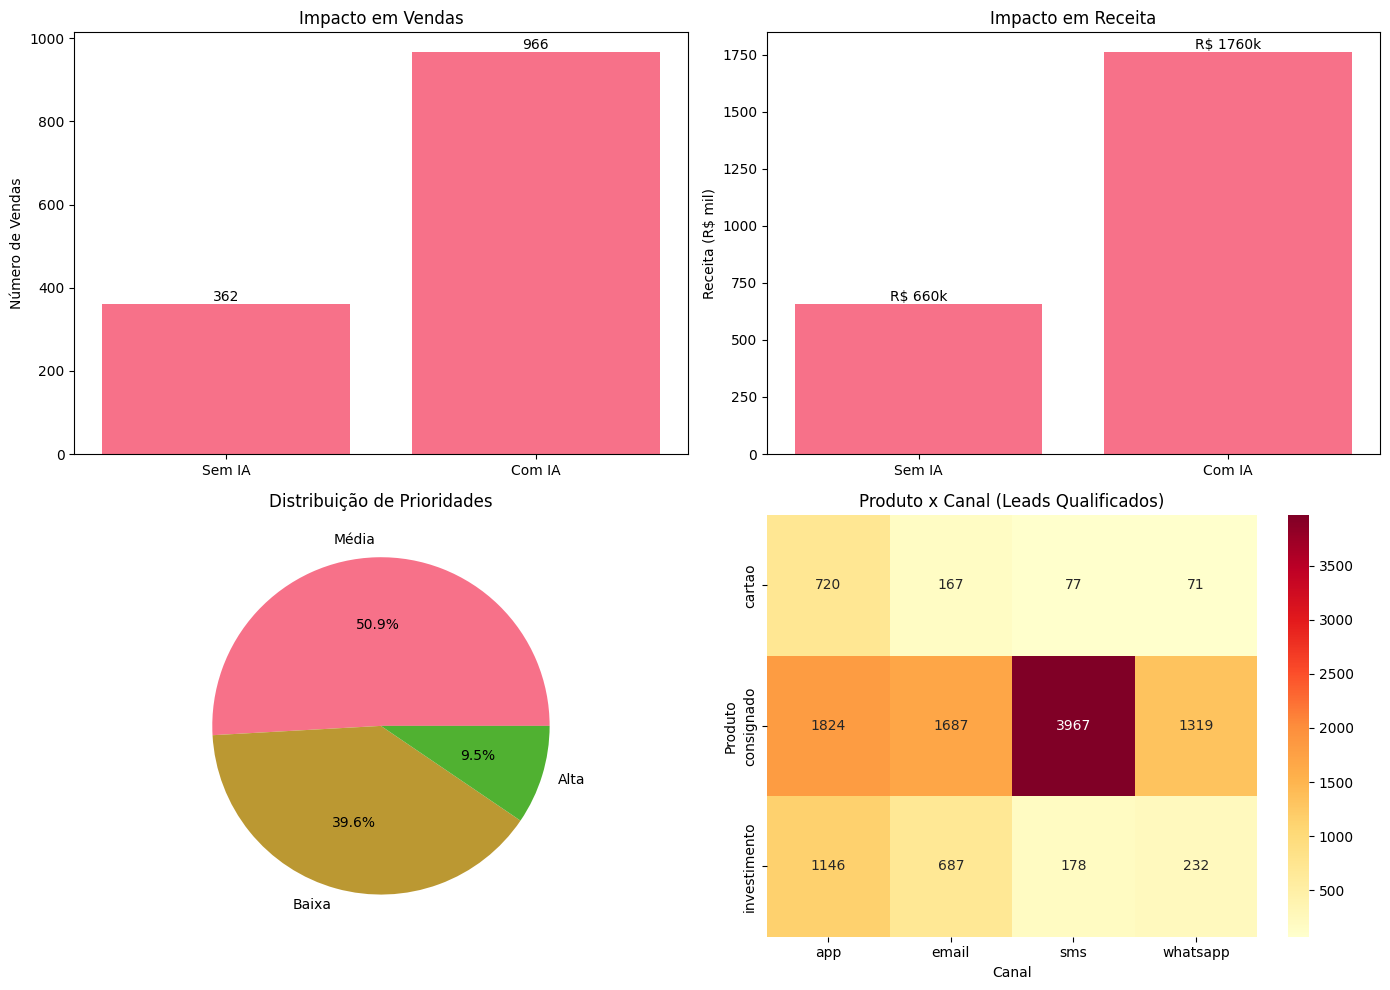

In [123]:
# =============================================================================
# 10. KPIs DE NEGÓCIO E SIMULAÇÃO DE IMPACTO
# =============================================================================

print("\n" + "="*80)
print("ETAPA 9: KPIs DE NEGÓCIO E SIMULAÇÃO DE IMPACTO")
print("="*80)

def calcular_kpis_negocio(df_rec: pd.DataFrame) -> Dict:
    """
    Simula KPIs de negócio baseado nas recomendações.
    """
    # Parâmetros de negócio (estimativas)
    PARAMS = {
        'taxa_conversao_base': 0.03,  # 3% sem personalização
        'taxa_conversao_com_ia': 0.08,  # 8% com IA
        'ticket_medio': {
            'consignado': 15000,
            'cartao': 3000,
            'investimento': 8000
        },
        'margem': {
            'consignado': 0.15,
            'cartao': 0.25,
            'investimento': 0.08
        }
    }
    
    # Filtrar apenas prioridade alta/média
    df_qualificado = df_rec[df_rec['prioridade'].isin(['Alta', 'Média'])].copy()
    
    total_leads = len(df_qualificado)
    
    # Vendas esperadas
    vendas_base = int(total_leads * PARAMS['taxa_conversao_base'])
    vendas_com_ia = int(total_leads * PARAMS['taxa_conversao_com_ia'])
    uplift_vendas = vendas_com_ia - vendas_base
    uplift_percentual = ((vendas_com_ia / vendas_base) - 1) * 100
    
    # Receita por produto
    receita_base = 0
    receita_com_ia = 0
    
    dist_produtos = df_qualificado['produto_recomendado'].value_counts(normalize=True)
    
    for produto, proporcao in dist_produtos.items():
        ticket = PARAMS['ticket_medio'].get(produto, 5000)
        margem = PARAMS['margem'].get(produto, 0.15)
        
        vendas_prod_base = vendas_base * proporcao
        vendas_prod_ia = vendas_com_ia * proporcao
        
        receita_base += vendas_prod_base * ticket * margem
        receita_com_ia += vendas_prod_ia * ticket * margem
    
    uplift_receita = receita_com_ia - receita_base
    roi = (uplift_receita / 100000) * 100  # Assumindo custo de implementação de 100k
    
    kpis = {
        'total_leads_qualificados': total_leads,
        'vendas_base': vendas_base,
        'vendas_com_ia': vendas_com_ia,
        'uplift_vendas': uplift_vendas,
        'uplift_percentual': uplift_percentual,
        'receita_base': receita_base,
        'receita_com_ia': receita_com_ia,
        'uplift_receita': uplift_receita,
        'roi_estimado': roi
    }
    
    return kpis, df_qualificado

kpis, df_qualificado = calcular_kpis_negocio(df_recomendacoes)

print("💰 KPIs DE NEGÓCIO (SIMULADOS):")
print(f"\n📊 Leads Qualificados: {kpis['total_leads_qualificados']:,}")
print(f"\n🎯 VENDAS:")
print(f"   Sem IA (baseline): {kpis['vendas_base']:,} vendas")
print(f"   Com IA: {kpis['vendas_com_ia']:,} vendas")
print(f"   📈 Uplift: +{kpis['uplift_vendas']:,} vendas ({kpis['uplift_percentual']:.1f}%)")
print(f"\n💵 RECEITA (margem):")
print(f"   Sem IA: R$ {kpis['receita_base']:,.2f}")
print(f"   Com IA: R$ {kpis['receita_com_ia']:,.2f}")
print(f"   📈 Uplift: R$ {kpis['uplift_receita']:,.2f}")
print(f"\n💎 ROI Estimado: {kpis['roi_estimado']:.0f}%")

# Visualização de impacto
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Comparação de vendas
ax1 = axes[0, 0]
categorias = ['Sem IA', 'Com IA']
vendas = [kpis['vendas_base'], kpis['vendas_com_ia']]
bars = ax1.bar(categorias, vendas)
ax1.set_ylabel('Número de Vendas')
ax1.set_title('Impacto em Vendas')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}', ha='center', va='bottom')

# 2. Comparação de receita
ax2 = axes[0, 1]
receitas = [kpis['receita_base']/1000, kpis['receita_com_ia']/1000]
bars = ax2.bar(categorias, receitas)
ax2.set_ylabel('Receita (R$ mil)')
ax2.set_title('Impacto em Receita')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'R$ {height:.0f}k', ha='center', va='bottom')

# 3. Distribuição por prioridade
ax3 = axes[1, 0]
prior_dist = df_recomendacoes['prioridade'].value_counts()
ax3.pie(prior_dist.values, labels=prior_dist.index, autopct='%1.1f%%')
ax3.set_title('Distribuição de Prioridades')

# 4. Produto x Canal (Heatmap)
ax4 = axes[1, 1]
pivot_table = pd.crosstab(df_qualificado['produto_recomendado'], 
                          df_qualificado['canal_recomendado'])
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', ax=ax4)
ax4.set_title('Produto x Canal (Leads Qualificados)')
ax4.set_xlabel('Canal')
ax4.set_ylabel('Produto')

plt.tight_layout()
plt.show()

### 11. Esportação e Resumo final 📃

In [124]:
class SmartReachExporter:
    """Gerenciador de exportação e relatórios do SmartReach"""
    
    def __init__(
        self,
        timestamp: str = datetime.utcnow().strftime('%Y%m%d_%H%M%S'),
        user: str = 'andrecini'
    ):
        self.timestamp = timestamp
        self.user = user
        self.logger = logging.getLogger('SmartReachExporter')
    
    def exportar_recomendacoes(
        self,
        df_recomendacoes: pd.DataFrame,
        path: str = None
    ) -> str:
        """Exporta recomendações com nome de arquivo dinâmico"""
        # Definir nome do arquivo
        if not path:
            path = f'bmg_smartreach_recomendacoes_{self.timestamp}.csv'
        
        # Colunas dinâmicas baseadas nas disponíveis
        colunas_base = [
            'cliente_id', 'idade', 'renda_mensal', 'tipo_beneficio',
            'cluster', 'produto_recomendado', 'score_produto',
            'produto_alternativo', 'score_alternativo',
            'canal_recomendado', 'score_canal',
            'tom_linguagem', 'score_final', 'prioridade',
            'explicacao', 'mensagem_personalizada'
        ]
        
        colunas_export = [col for col in colunas_base if col in df_recomendacoes.columns]
        
        # Exportar
        df_export = df_recomendacoes[colunas_export].copy()
        df_export.to_csv(path, index=False, encoding='utf-8-sig')
        
        self.logger.info(f"Arquivo exportado: {path}")
        return path
    
    def gerar_metricas_modelo(
        self,
        modelos: Dict,
        dados_teste: Dict
    ) -> Dict:
        """Calcula métricas dos modelos"""
        metricas = {}
        
        # Métricas de clustering
        if 'clustering' in modelos:
            metricas['clustering'] = {
                'n_clusters': len(np.unique(modelos['clustering'].labels_)),
                'silhouette': silhouette_score(
                    dados_teste['X_cluster'],
                    modelos['clustering'].labels_
                )
            }
        
        # Métricas de produto
        if 'produto' in modelos:
            y_pred_prod = modelos['produto'].predict(dados_teste['X_produto'])
            metricas['produto'] = {
                'accuracy': accuracy_score(dados_teste['y_produto'], y_pred_prod),
                'f1_macro': f1_score(
                    dados_teste['y_produto'],
                    y_pred_prod,
                    average='macro'
                )
            }
        
        # Métricas de canal
        if 'canal' in modelos:
            y_pred_canal = modelos['canal'].predict(dados_teste['X_canal'])
            metricas['canal'] = {
                'accuracy': accuracy_score(dados_teste['y_canal'], y_pred_canal),
                'top2_accuracy': self.calcular_top2_accuracy(
                    modelos['canal'],
                    dados_teste['X_canal'],
                    dados_teste['y_canal']
                )
            }
        
        return metricas
    
    def calcular_top2_accuracy(
        self,
        modelo,
        X_test: np.ndarray,
        y_test: np.ndarray
    ) -> float:
        """Calcula Top-2 Accuracy para canal"""
        proba = modelo.predict_proba(X_test)
        top2_preds = np.argsort(proba, axis=1)[:, -2:]
        return np.mean([y in preds for y, preds in zip(y_test, top2_preds)])
    
    def gerar_resumo_executivo(
        self,
        df_original: pd.DataFrame,
        df_recomendacoes: pd.DataFrame,
        metricas_modelos: Dict,
        kpis_negocio: Dict,
        arquivo_export: str
    ) -> str:
        """Gera relatório executivo formatado"""
        
        # Calcular métricas de qualificação
        df_qualificado = df_recomendacoes[
            df_recomendacoes['prioridade'].isin(['Alta', 'Média'])
        ]
        
        resumo = f"""
{'='*80}
RESUMO EXECUTIVO - BMG SMARTREACH MVP
{'='*80}

🎯 DADOS PROCESSADOS:
   • {len(df_original):,} clientes analisados
   • {len(df_qualificado):,} leads qualificados (prioridade alta/média)
   • {df_original['cluster'].nunique()} perfis de clientes identificados

📊 MODELOS TREINADOS:
   • Clusterização: {metricas_modelos['clustering']['n_clusters']} clusters (Silhouette: {metricas_modelos['clustering']['silhouette']:.3f})
   • Propensão ao Produto: Accuracy {metricas_modelos['produto']['accuracy']:.1%}
   • Canal Ideal: Accuracy {metricas_modelos['canal']['accuracy']:.1%} (Top-2: {metricas_modelos['canal']['top2_accuracy']:.1%})
   • Mensagens: {len(df_recomendacoes)} mensagens personalizadas

💰 IMPACTO DE NEGÓCIO (SIMULADO):
   • Uplift em vendas: +{kpis_negocio['uplift_percentual']:.0f}% ({kpis_negocio['uplift_vendas']:,} vendas adicionais)
   • Receita incremental: R$ {kpis_negocio['uplift_receita']:,.2f}
   • ROI estimado: {kpis_negocio['roi_estimado']:.0f}%

🚀 PRÓXIMOS PASSOS:
   1. Validar com campanha piloto (A/B test)
   2. Ajustar modelos com dados reais de conversão
   3. Implementar monitoramento de performance
   4. Expandir para outros produtos/segmentos

{'='*80}
✅ MVP CONCLUÍDO COM SUCESSO!
{'='*80}

📁 ARQUIVOS GERADOS:
   • {arquivo_export} - Recomendações completas

🎨 VISUALIZAÇÕES GERADAS:
   ✓ Análise de clusters dinâmica
   ✓ PCA 2D dos perfis
   ✓ Matrizes de confusão (produto e canal)
   ✓ Feature importances
   ✓ KPIs de negócio comparativos
   ✓ Heatmap produto x canal
   ✓ Análise de tons por cluster
"""
        return resumo

# Exemplo de uso
if __name__ == "__main__":
    # Inicializar exporter
    exporter = SmartReachExporter()
    
    # Exportar recomendações
    arquivo_export = exporter.exportar_recomendacoes(df_recomendacoes)
    
    # Calcular métricas dos modelos
    metricas_modelos = exporter.gerar_metricas_modelo(
        modelos={
            'clustering': kmeans,  # seu modelo de clustering
            'produto': modelo_produto,
            'canal': modelo_canal
        },
        dados_teste={
            'X_cluster': X_viz_scaled,
            'X_produto': X_test_prod,
            'y_produto': y_test_prod,
            'X_canal': X_test_canal,
            'y_canal': y_test_canal
        }
    )
    
    # Gerar resumo executivo
    resumo = exporter.gerar_resumo_executivo(
        df_original=df,
        df_recomendacoes=df_recomendacoes,
        metricas_modelos=metricas_modelos,
        kpis_negocio=kpis,
        arquivo_export=arquivo_export
    )
    
    print(resumo)

2025-10-11 00:39:30,554 - SmartReachExporter - INFO - Arquivo exportado: bmg_smartreach_recomendacoes_20251011_033930.csv



RESUMO EXECUTIVO - BMG SMARTREACH MVP

🎯 DADOS PROCESSADOS:
   • 20,000 clientes analisados
   • 12,075 leads qualificados (prioridade alta/média)
   • 4 perfis de clientes identificados

📊 MODELOS TREINADOS:
   • Clusterização: 4 clusters (Silhouette: 0.168)
   • Propensão ao Produto: Accuracy 57.4%
   • Canal Ideal: Accuracy 38.1% (Top-2: 69.5%)
   • Mensagens: 20000 mensagens personalizadas

💰 IMPACTO DE NEGÓCIO (SIMULADO):
   • Uplift em vendas: +167% (604 vendas adicionais)
   • Receita incremental: R$ 1,100,706.59
   • ROI estimado: 1101%

🚀 PRÓXIMOS PASSOS:
   1. Validar com campanha piloto (A/B test)
   2. Ajustar modelos com dados reais de conversão
   3. Implementar monitoramento de performance
   4. Expandir para outros produtos/segmentos

✅ MVP CONCLUÍDO COM SUCESSO!

📁 ARQUIVOS GERADOS:
   • bmg_smartreach_recomendacoes_20251011_033930.csv - Recomendações completas

🎨 VISUALIZAÇÕES GERADAS:
   ✓ Análise de clusters dinâmica
   ✓ PCA 2D dos perfis
   ✓ Matrizes de confusão

### 12. Teste Interativo 🧪